In [118]:
# Importing libraries

import pandas as pd
import numpy as np
from scipy.stats import norm
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import statsmodels as sm
import statsmodels.api as sm

In [119]:
# Downloading data

df = pd.read_excel(r"C:\Users\Asus\Desktop\master's thesis\Datasets\new dataset\Master_Thesis_Data Experiment Data Cutting without crisis (No IR).xlsx")
df.drop(columns = 'International Investment', inplace=True)
df

,Country,Date,Dependent Variable,Credit to GDP,Housing price,GDP growth,Inflation,3 month money market rate,Gross fixed capital formation to GDP,Account to GDP,10 Year Government Bond Rate,Unemployment,Share Price
0,DE,1970-Q1,0,NaN,31.535927,-1.595662,2.894135,9.536667,-1.991301,NaN,7.833333,NaN,10.873150
1,DE,1970-Q2,0,NaN,32.363393,3.975818,3.335860,9.890000,8.214446,NaN,8.400000,NaN,9.807037
2,DE,1970-Q3,0,NaN,33.204478,1.867836,3.566009,9.370000,5.363654,NaN,8.533334,NaN,9.271091
3,DE,1970-Q4,0,85.6,34.062502,0.847607,4.000000,8.830000,-0.028774,NaN,8.500000,NaN,8.835394
4,DE,1971-Q1,0,85.8,34.907015,-1.921103,4.441154,7.476666,-1.492452,NaN,7.766667,NaN,9.699077
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595,CA,2018-Q4,0,216.2,129.660633,0.340870,2.035623,2.112573,-1.296769,-2.919957,2.318050,5.700000,104.797200
2596,CA,2019-Q1,0,217.0,129.556938,0.070759,1.611685,1.997995,1.606348,-3.080937,1.857795,5.800000,109.103100
2597,CA,2019-Q2,0,219.3,128.061840,0.988110,2.148389,1.859268,0.004727,-1.128215,1.616548,5.566667,114.186500
2598,CA,2019-Q3,0,221.0,129.734163,0.374027,1.939334,1.837570,2.206205,-2.178369,1.362776,5.733333,114.896600


In [120]:
# Filling NaN values with mean

df['Credit to GDP'].fillna(df['Credit to GDP'].mean(), inplace=True)
df['Housing price'].fillna(df['Housing price'].mean(), inplace=True)
df['GDP growth'].fillna(df['GDP growth'].mean(), inplace=True)
df['Inflation'].fillna(df['Inflation'].mean(), inplace=True)
df['3 month money market rate'].fillna(df['3 month money market rate'].mean(), inplace=True)
df['Gross fixed capital formation to GDP'].fillna(df['Gross fixed capital formation to GDP'].mean(), inplace=True)
df['Account to GDP'].fillna(df['Account to GDP'].mean(), inplace=True)
df['10 Year Government Bond Rate'].fillna(df['10 Year Government Bond Rate'].mean(), inplace=True)
df['Unemployment'].fillna(df['Unemployment'].mean(), inplace=True)
df['Share Price'].fillna(df['Share Price'].mean(), inplace=True)

In [121]:
# Creating new variables: Growths and Dummy

df['Share Price Growth'] = df['Share Price'].pct_change() * 100
df['Housing Price Growth'] = df['Housing price'].pct_change() * 100

df['C-GDP/3MMR_dummy'] = ((df['Credit to GDP'] > df['Credit to GDP'].mean()) & (df['3 month money market rate'] > df['3 month money market rate'].mean()))
df['C-GDP/3MMR_dummy'] = df['C-GDP/3MMR_dummy'].astype(int)

df['GDP/UER_dummy'] = ((df['GDP growth'] < 0) & (df['Unemployment'] > df['Unemployment'].mean())).astype(int)

df['INF/10YGB_dummy'] = ((df['Inflation'] > df['Inflation'].mean()) & (df['10 Year Government Bond Rate'] > df['10 Year Government Bond Rate'].mean())).astype(int)

df['GDP/SP_dummy'] = (df['GDP growth'] < df['GDP growth'].mean()) & (df['Share Price Growth'] < df['Share Price Growth'].mean())
df['GDP/SP_dummy'] = df['GDP/SP_dummy'].astype(int)

df['C-GDP/UER_dummy'] = (df['Credit to GDP'] > df['Credit to GDP'].mean()) & (df['Unemployment'] > df['Unemployment'].mean())
df['C-GDP/UER_dummy'] = df['C-GDP/UER_dummy'].astype(int)

In [122]:
# Appliying HP (1 side) filter to Credit to GDP

import statsmodels as sm


def apply_hp_filter(country_df, variable_name):
    start_index = country_df[variable_name].notna().idxmax()
    result = country_df.loc[start_index:]
    variable = result[variable_name].dropna()

    cred_c, _ = sm.tsa.filters.hp_filter.hpfilter(variable)

    cred_c_1s = np.zeros(len(cred_c))
    cred_c_1s[0:2] = variable.iloc[0:2]

    for i in range(2, len(cred_c)):
        temp_c, _ = sm.tsa.filters.hp_filter.hpfilter((100 * np.log(variable.iloc[:i])))
        cred_c_1s[i] = temp_c.iloc[-1]

    return pd.Series(cred_c_1s, index=variable.index, name=f'{variable_name}_cycle')

df['Credit to GDP_cycle'] = np.nan

for country in df['Country'].unique():
    country_df = df[df['Country'] == country]
    result_series = apply_hp_filter(country_df, 'Credit to GDP')  
    df.loc[df['Country'] == country, 'Credit to GDP_cycle'] = result_series

In [123]:
# Appliying HP (1 side) filter to Account to GDP

# import numpy as np
# import pandas as pd
# import statsmodels as sm
# import matplotlib.pyplot as plt


# def apply_hp_filter(country_df, variable_name, lamb=100_000):
#     start_index = country_df[variable_name].notna().idxmax()
#     result = country_df.loc[start_index:]
#     variable = result[variable_name].dropna()

#     cred_c, _ = sm.tsa.filters.hp_filter.hpfilter(variable, lamb=lamb)

#     cred_c_1s = np.zeros(len(cred_c))
#     cred_c_1s[0:2] = variable.iloc[0:2]

#     for i in range(2, len(cred_c)):
#         temp_c, _ = sm.tsa.filters.hp_filter.hpfilter((100 * np.log(variable.iloc[:i])), lamb=lamb)
#         cred_c_1s[i] = temp_c.iloc[-1]

#     return pd.Series(cred_c_1s, index=variable.index, name=f'{variable_name}_cycle')

# df['Account to GDP_cycle'] = np.nan

# for country in df['Country'].unique():
#     country_df = df[df['Country'] == country]
#     result_series = apply_hp_filter(country_df, 'Account to GDP') 
#     df.loc[df['Country'] == country, 'Account to GDP_cycle'] = result_series

In [124]:
# Appliying HP (1 side) filter to Gross fixed capital formation to GDP

# import numpy as np
# import pandas as pd
# import statsmodels as sm
# import matplotlib.pyplot as plt


# def apply_hp_filter(country_df, variable_name, lamb=100_000):
#     start_index = country_df[variable_name].notna().idxmax()
#     result = country_df.loc[start_index:]
#     variable = result[variable_name].dropna()

#     cred_c, _ = sm.tsa.filters.hp_filter.hpfilter(variable, lamb=lamb)

#     cred_c_1s = np.zeros(len(cred_c))
#     cred_c_1s[0:2] = variable.iloc[0:2]

#     for i in range(2, len(cred_c)):
#         temp_c, _ = sm.tsa.filters.hp_filter.hpfilter((100 * np.log(variable.iloc[:i])), lamb=lamb)
#         cred_c_1s[i] = temp_c.iloc[-1]

#     return pd.Series(cred_c_1s, index=variable.index, name=f'{variable_name}_cycle')

# df['Gross fixed capital formation to GDP_cycle'] = np.nan

# for country in df['Country'].unique():
#     country_df = df[df['Country'] == country]
#     result_series = apply_hp_filter(country_df, 'Gross fixed capital formation to GDP')  
#     df.loc[df['Country'] == country, 'Gross fixed capital formation to GDP_cycle'] = result_series

In [125]:
# Appliying HP (1 side) filter to Housing price

import numpy as np
import pandas as pd
import statsmodels as sm
import matplotlib.pyplot as plt


def apply_hp_filter(country_df, variable_name, lamb=100_000):
    start_index = country_df[variable_name].notna().idxmax()
    result = country_df.loc[start_index:]
    variable = result[variable_name].dropna()

    cred_c, _ = sm.tsa.filters.hp_filter.hpfilter(variable, lamb=lamb)

    cred_c_1s = np.zeros(len(cred_c))
    cred_c_1s[0:2] = variable.iloc[0:2]

    for i in range(2, len(cred_c)):
        temp_c, _ = sm.tsa.filters.hp_filter.hpfilter((100 * np.log(variable.iloc[:i])), lamb=lamb)
        cred_c_1s[i] = temp_c.iloc[-1]

    return pd.Series(cred_c_1s, index=variable.index, name=f'{variable_name}_cycle')

df['Housing price_cycle'] = np.nan

for country in df['Country'].unique():
    country_df = df[df['Country'] == country]
    result_series = apply_hp_filter(country_df, 'Housing price')  
    df.loc[df['Country'] == country, 'Housing price_cycle'] = result_series

In [126]:
# Appliying HP (1 side) filter to Share price

import numpy as np
import pandas as pd
import statsmodels as sm
import matplotlib.pyplot as plt


def apply_hp_filter(country_df, variable_name, lamb=100_000):
    start_index = country_df[variable_name].notna().idxmax()
    result = country_df.loc[start_index:]
    variable = result[variable_name].dropna()

    cred_c, _ = sm.tsa.filters.hp_filter.hpfilter(variable, lamb=lamb)

    cred_c_1s = np.zeros(len(cred_c))
    cred_c_1s[0:2] = variable.iloc[0:2]

    for i in range(2, len(cred_c)):
        temp_c, _ = sm.tsa.filters.hp_filter.hpfilter((100 * np.log(variable.iloc[:i])), lamb=lamb)
        cred_c_1s[i] = temp_c.iloc[-1]

    return pd.Series(cred_c_1s, index=variable.index, name=f'{variable_name}_cycle')

df['Share Price_cycle'] = np.nan

for country in df['Country'].unique():
    country_df = df[df['Country'] == country]
    result_series = apply_hp_filter(country_df, 'Share Price')  
    df.loc[df['Country'] == country, 'Share Price_cycle'] = result_series

In [129]:
df.describe()

,Dependent Variable,Credit to GDP,Housing price,GDP growth,Inflation,3 month money market rate,Gross fixed capital formation to GDP,Account to GDP,10 Year Government Bond Rate,Unemployment,...,Share Price Growth,Housing Price Growth,C-GDP/3MMR_dummy,GDP/UER_dummy,INF/10YGB_dummy,GDP/SP_dummy,C-GDP/UER_dummy,Credit to GDP_cycle,Housing price_cycle,Share Price_cycle
count,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,...,2599.000000,2599.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2.600000e+03
mean,0.086538,142.226181,59.362759,0.575281,4.565236,5.226277,0.613815,1.194811,5.836522,6.989920,...,1.391727,0.955414,0.061154,0.138846,0.160769,0.260769,0.166538,1.578725,-2.730328,6.710425e-01
std,0.281212,47.099879,38.389157,1.039398,4.822270,4.054860,4.675077,3.710111,3.225064,2.452352,...,10.635412,6.646831,0.239658,0.345852,0.367389,0.439139,0.372635,13.352073,11.302190,2.759460e+01
min,0.000000,51.400000,1.997250,-6.477614,-2.200000,-0.776667,-47.053800,-12.853940,-0.544038,1.066667,...,-99.377416,-98.224667,0.000000,0.000000,0.000000,0.000000,0.000000,-60.117228,-44.936867,-2.255797e+02
25%,0.000000,111.775000,26.026571,0.072792,1.556106,2.140300,-0.899011,-0.344180,3.880264,5.533333,...,-2.372057,0.037544,0.000000,0.000000,0.000000,0.000000,0.000000,-0.936096,-9.578531,-1.156265e+01
50%,0.000000,138.700000,57.060624,0.595864,2.731913,5.226277,0.594571,1.194811,5.836522,6.989920,...,1.562988,1.190135,0.000000,0.000000,0.000000,0.000000,0.000000,0.002098,-1.058887,5.790525e-09
75%,0.000000,164.800000,93.543767,1.107636,6.268218,6.609167,2.128210,1.404268,7.584750,8.200000,...,6.438461,2.348737,0.000000,0.000000,0.000000,1.000000,0.000000,1.112089,4.411679,1.408065e+01
max,1.000000,294.300000,174.705745,6.094493,46.239230,20.737500,161.146555,19.002730,17.073330,18.100000,...,51.582402,21.641567,1.000000,1.000000,1.000000,1.000000,1.000000,142.226181,59.362759,1.157613e+02


Visualization 

In [130]:
df_crisis = df[df['Dependent Variable'] == 1]
df_tranquil = df[df['Dependent Variable'] == 0]

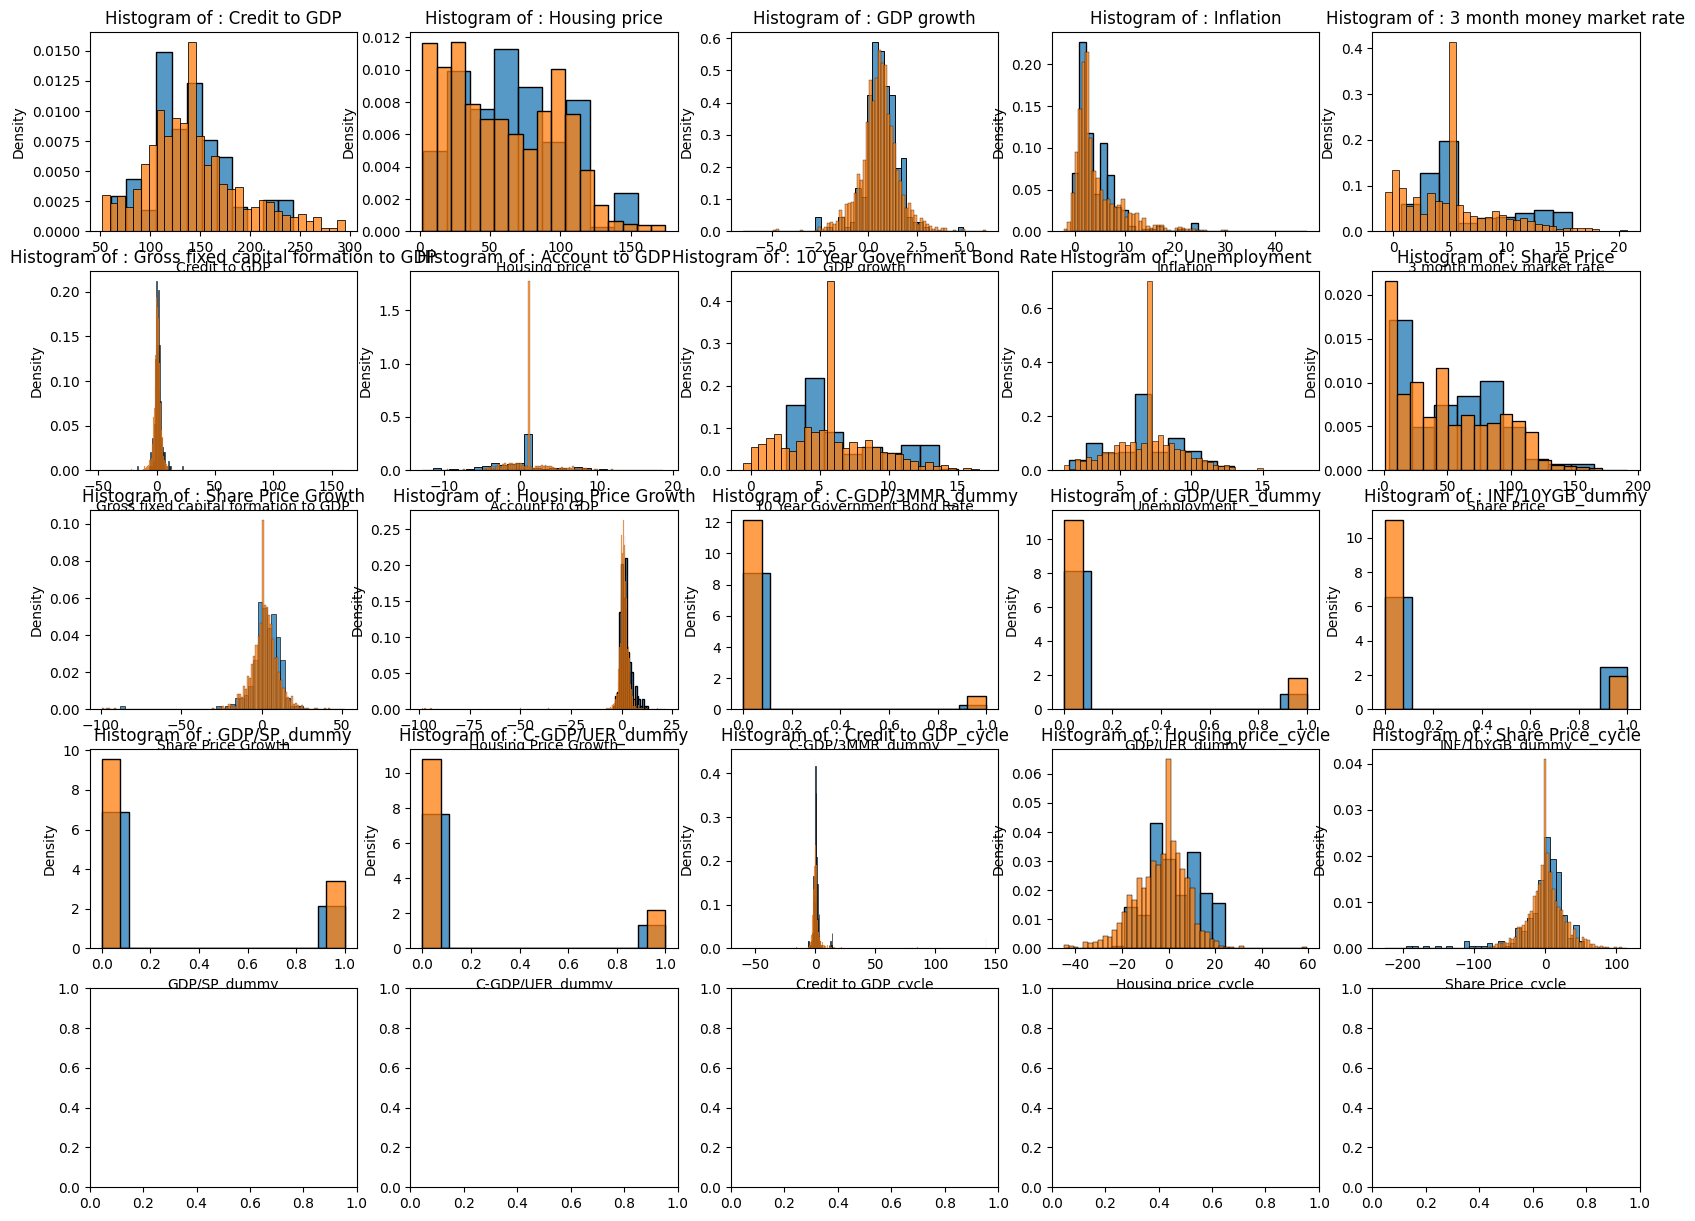

In [131]:
fig, axes = plt.subplots(ncols=5, nrows=5, figsize=(20, 15))
for i, ax in zip(df.columns[3:], axes.flat):
    sns.histplot(x=df_crisis[i], ax=ax, stat='density').set(title=f"Histogram of : {i}", xlabel="")
    sns.histplot(x=df_tranquil[i], ax=ax, color='C1', stat='density')
plt.show()

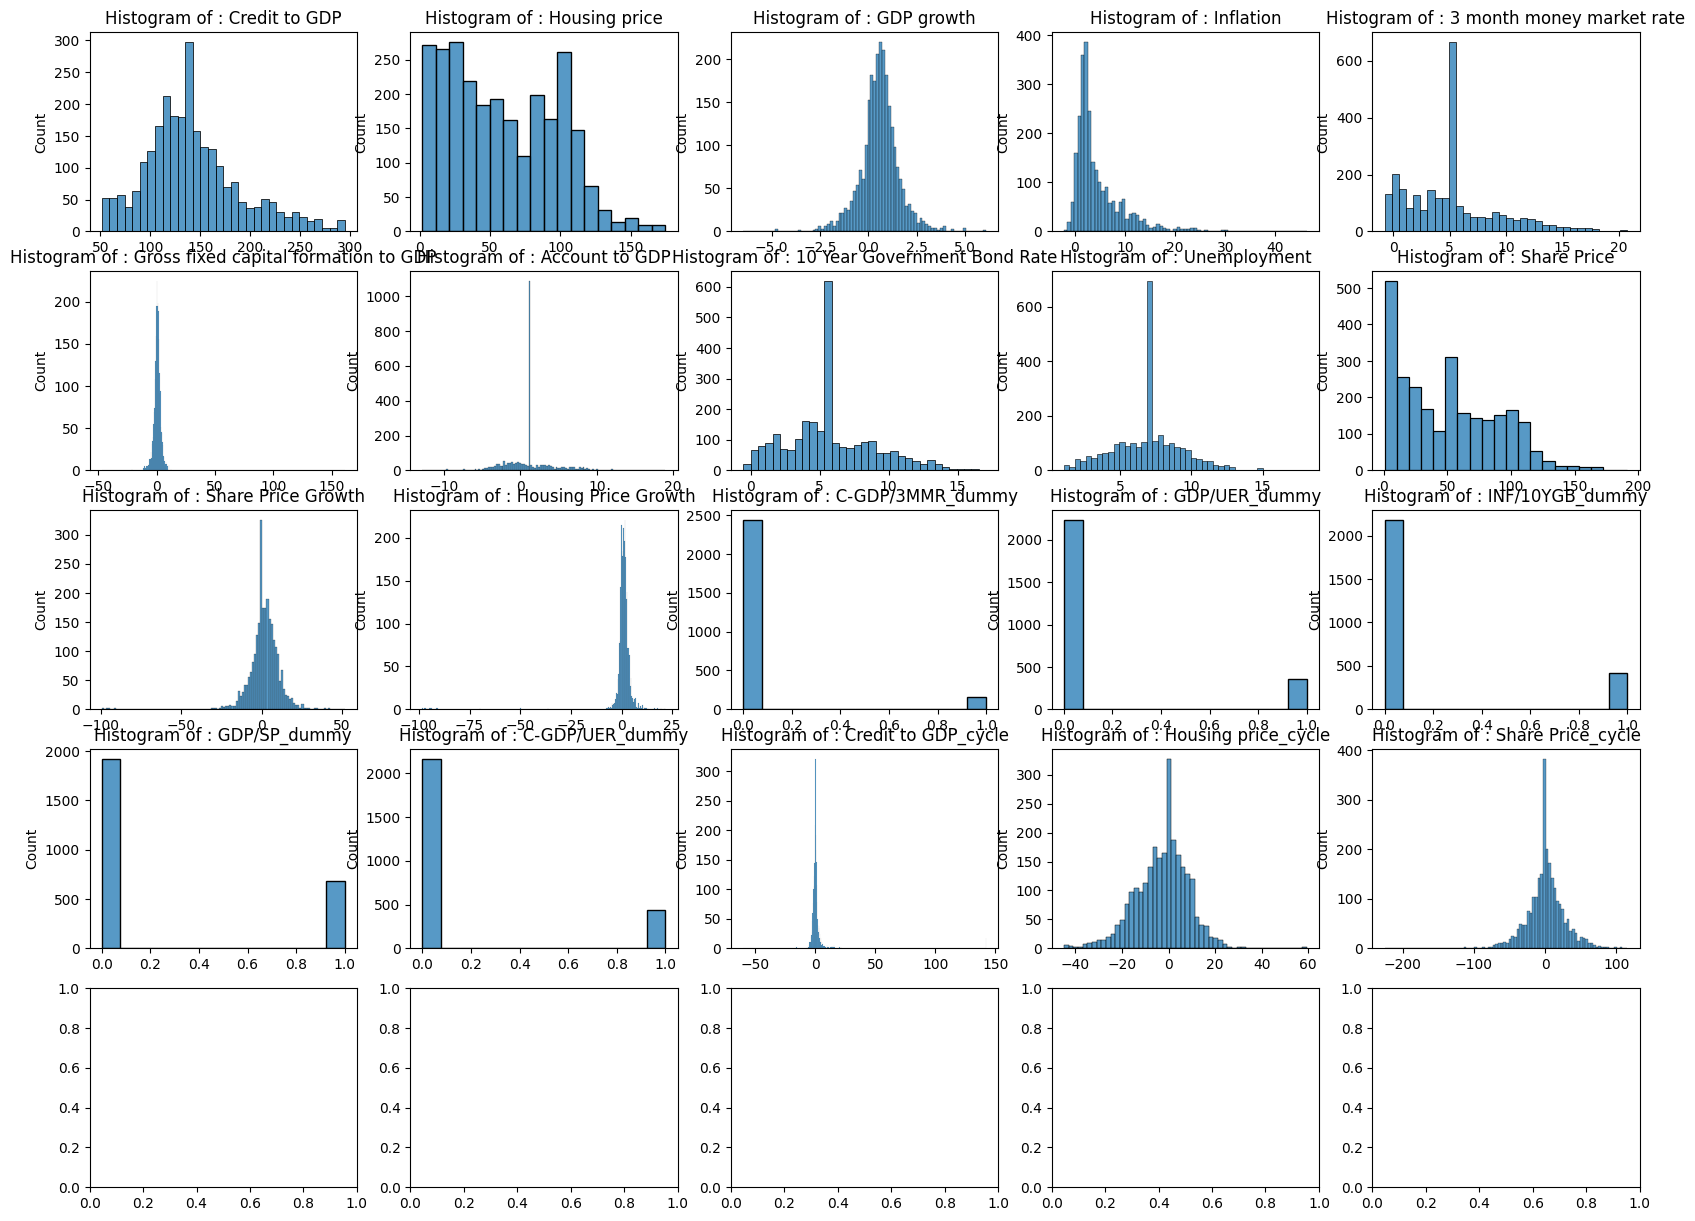

In [132]:
fig, axes = plt.subplots(ncols=5, nrows=5, figsize=(20, 15))
for i, ax in zip(df.columns[3:], axes.flat):
    sns.histplot(x=df[i], ax=ax).set(title=f"Histogram of : {i}", xlabel="")
plt.show()

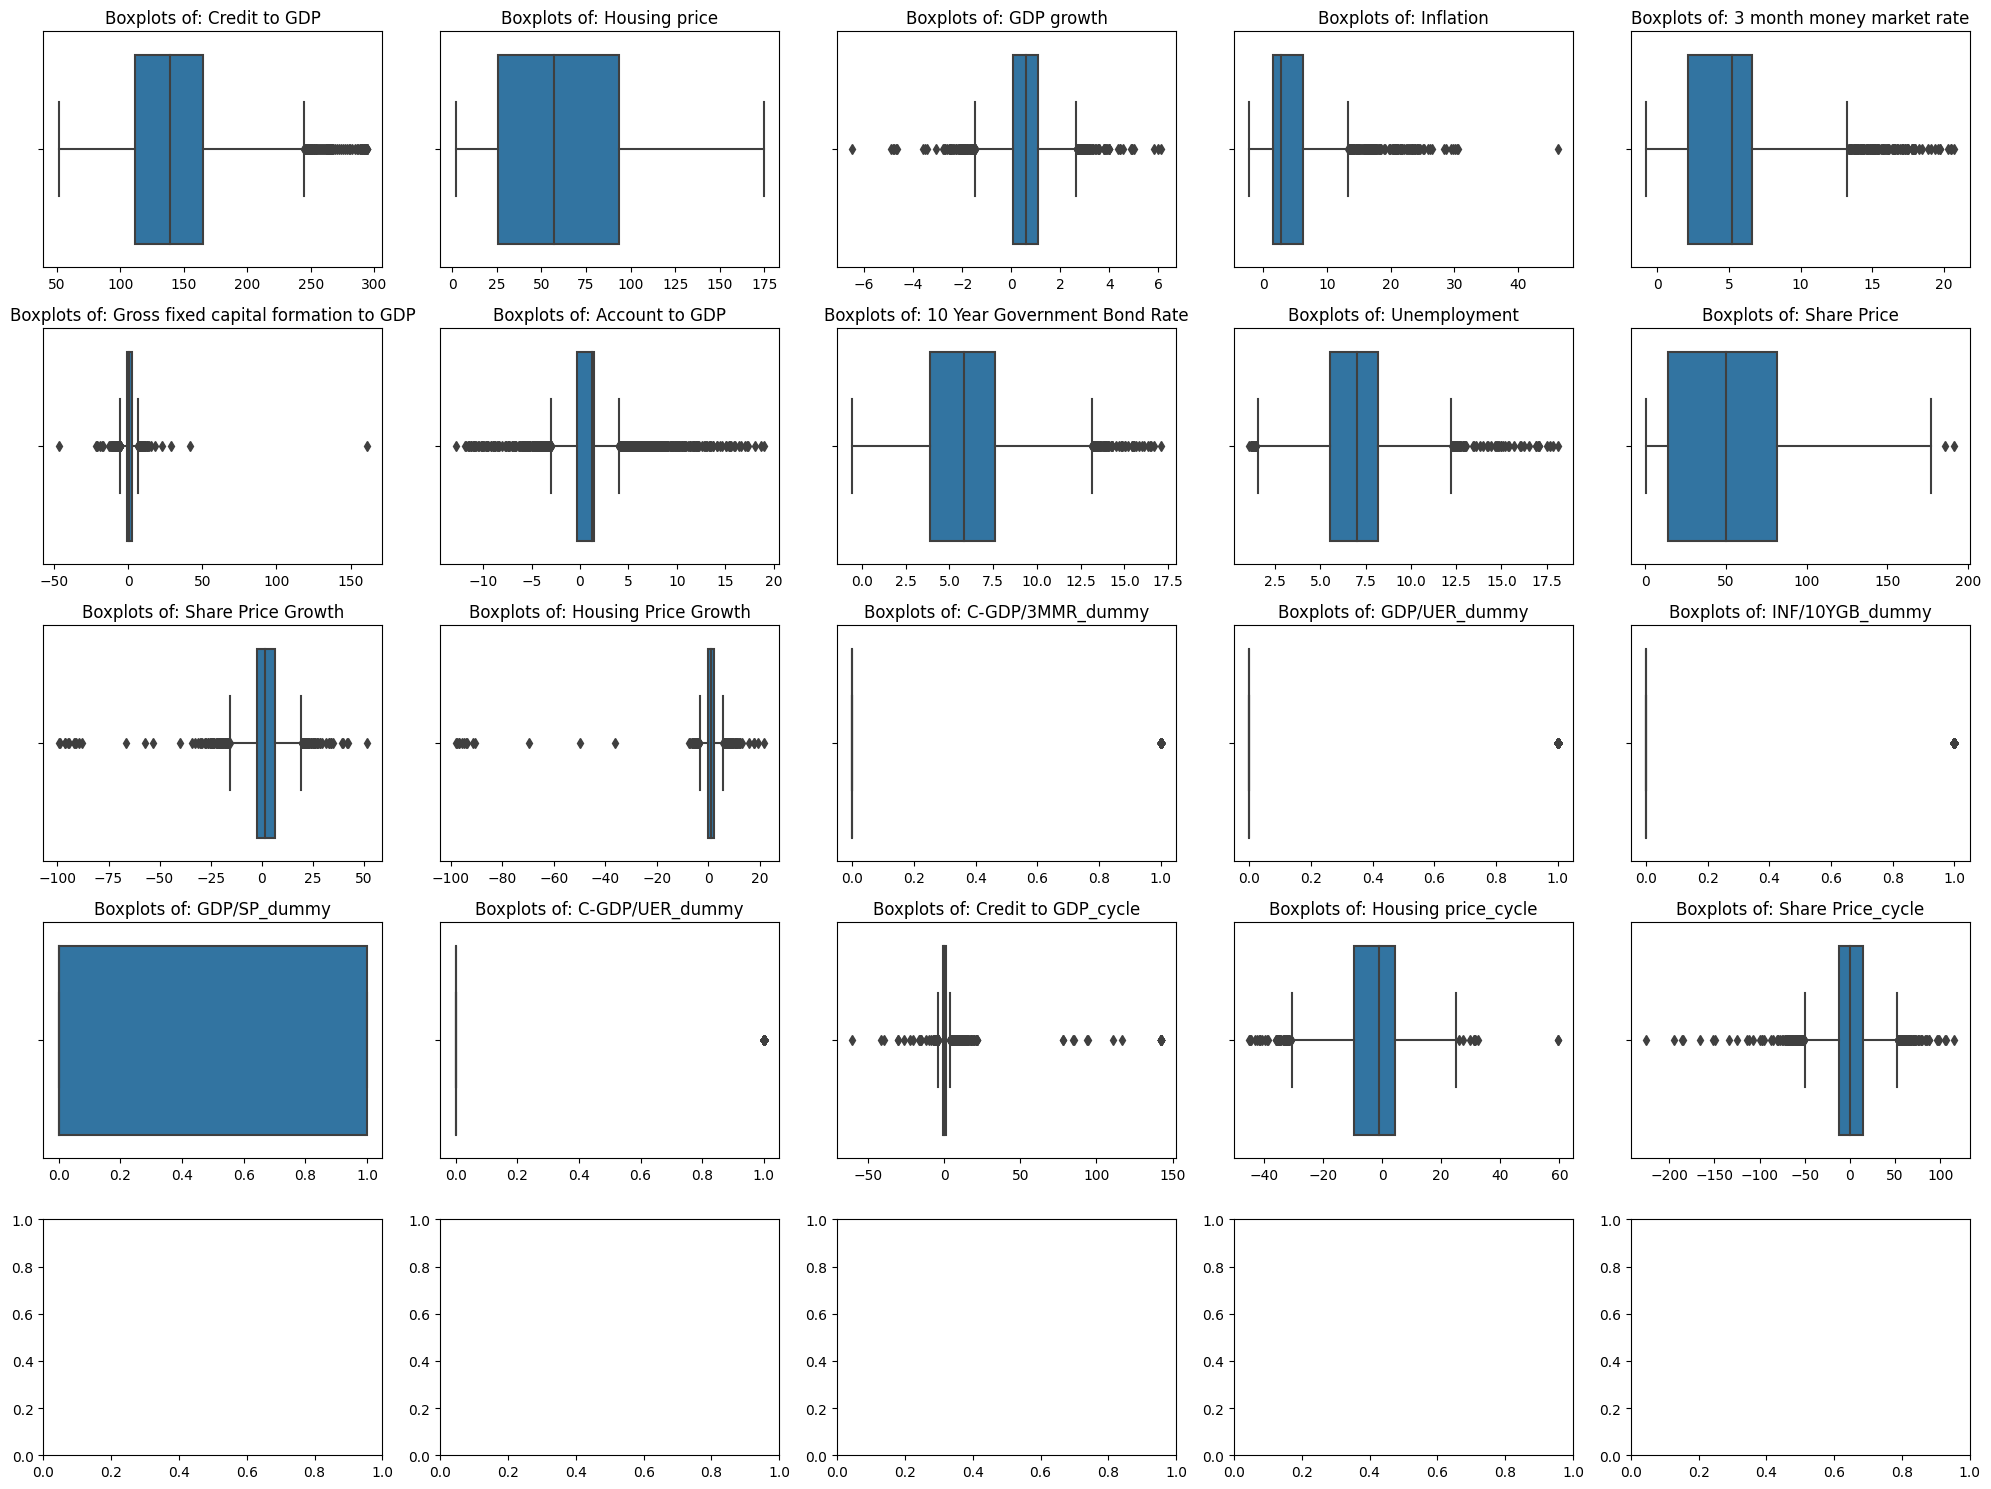

In [133]:
numeric_columns = df.select_dtypes(include='number')

fig, axes = plt.subplots(ncols=5, nrows=5, figsize=(20, 15))

for i, ax in zip(numeric_columns.columns[1:], axes.flat):
    sns.boxplot(x=numeric_columns[i], ax=ax, orient='h')
    ax.set(title=f"Boxplots of: {i}", xlabel="")

plt.tight_layout()
plt.show()

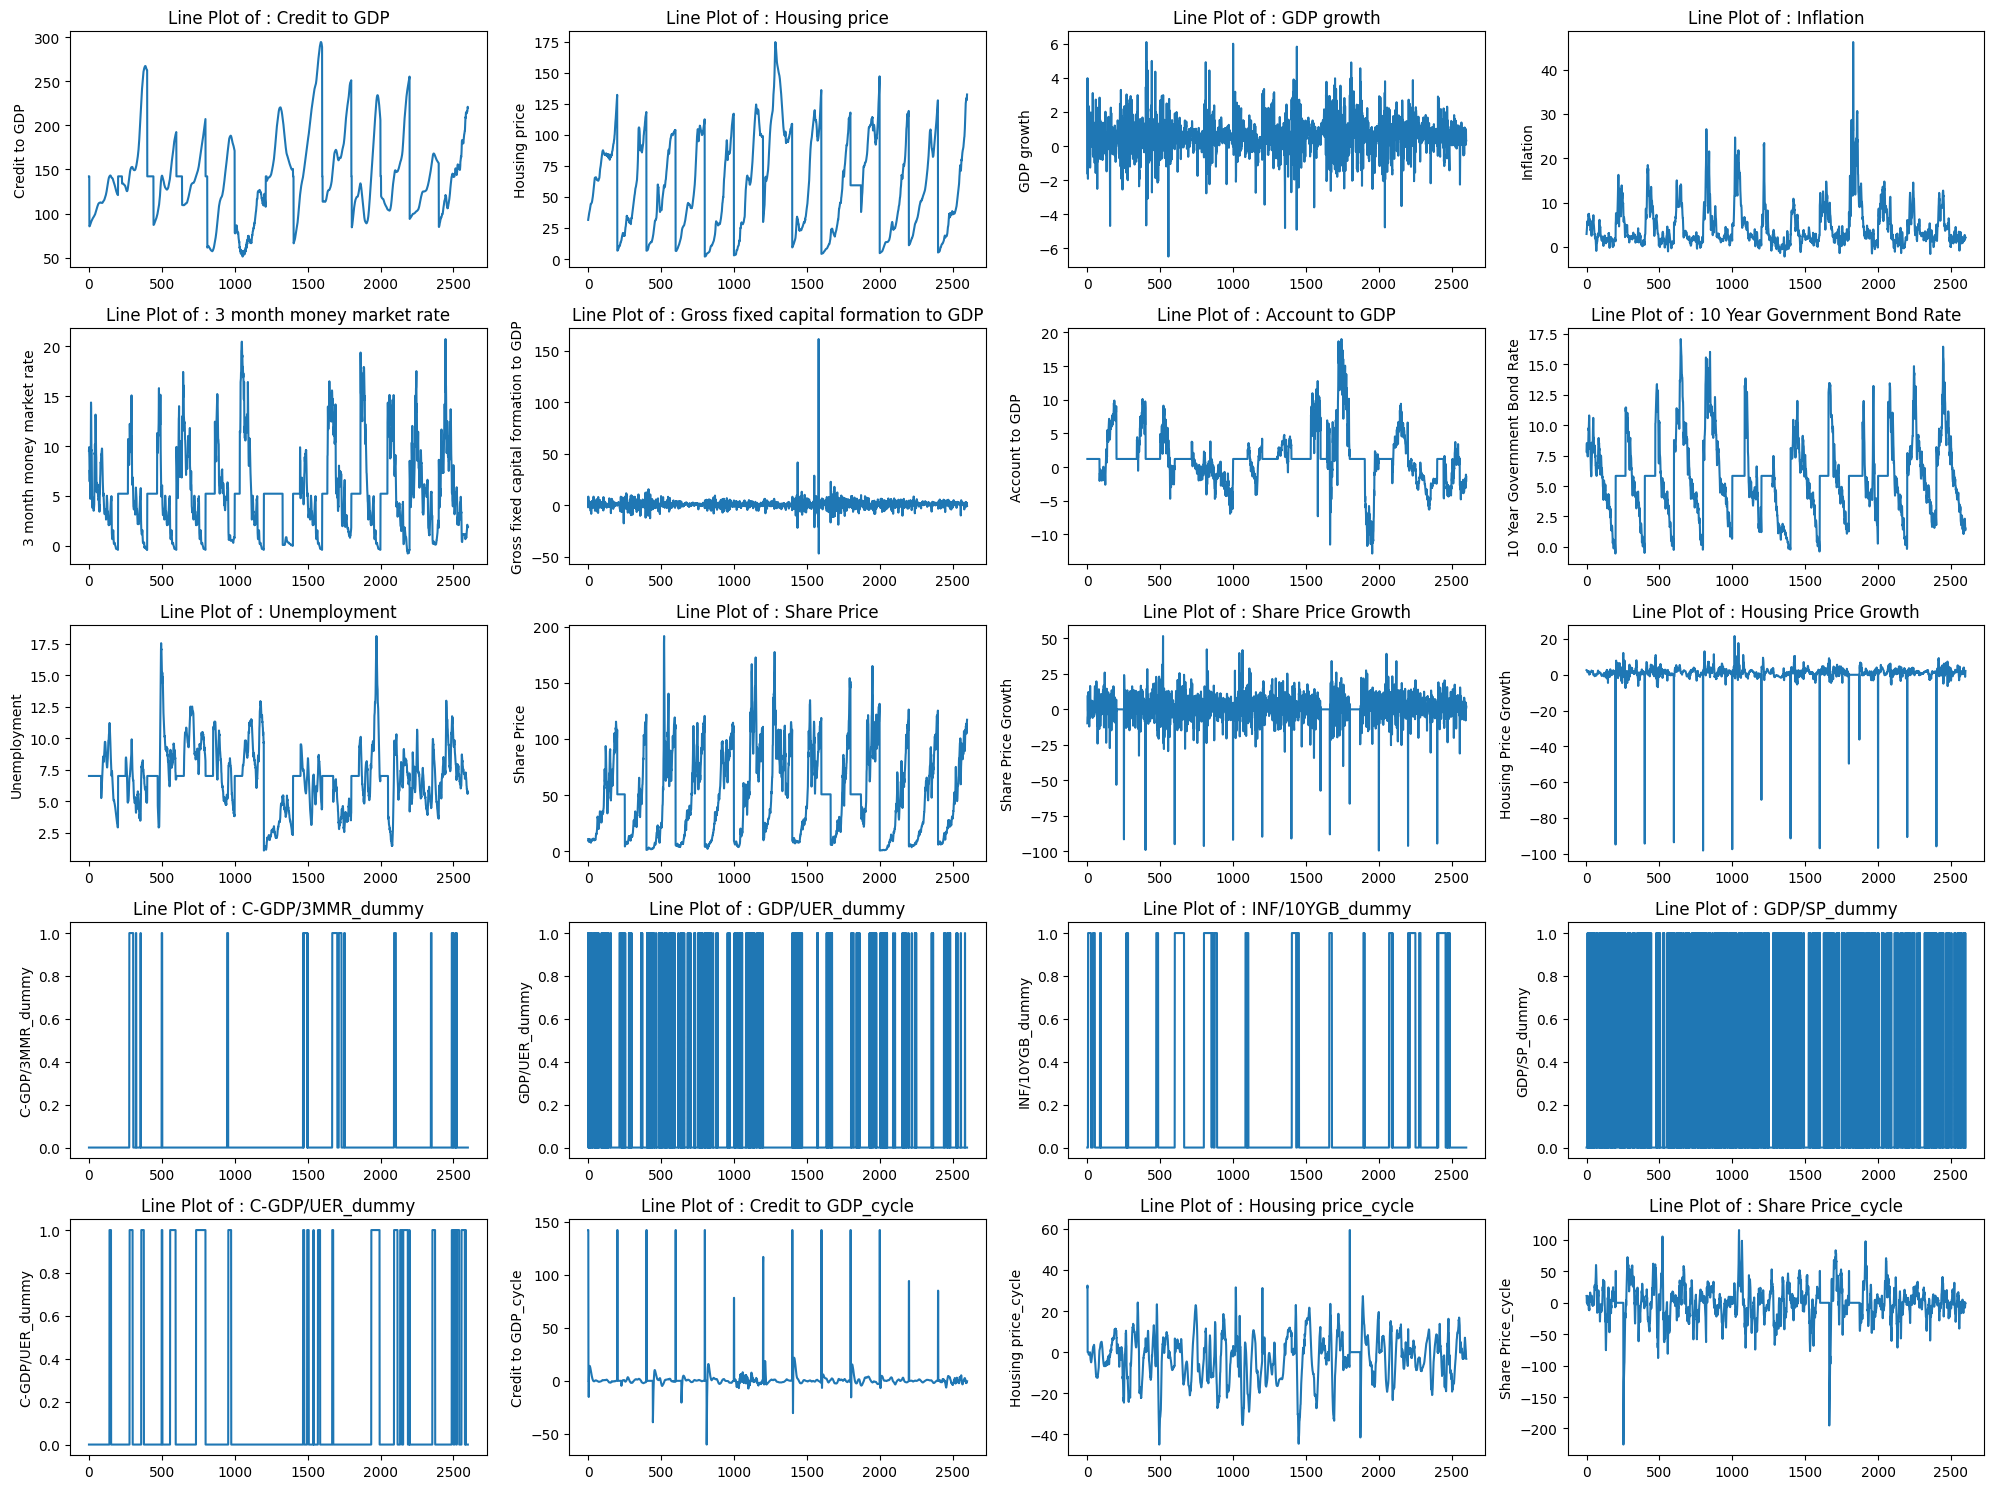

In [134]:
num_variables = len(df.columns) - 3
num_plots = num_variables
num_cols = 4
num_rows = (num_plots - 1) // num_cols + 1
fig, axes = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(20, 15))

for i, ax in zip(df.columns[3:], axes.flat):
    sns.lineplot(data=df, x=df.index, y=df[i], ax=ax)
    ax.set(title=f"Line Plot of : {i}", xlabel="")

for i in range(num_plots, num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

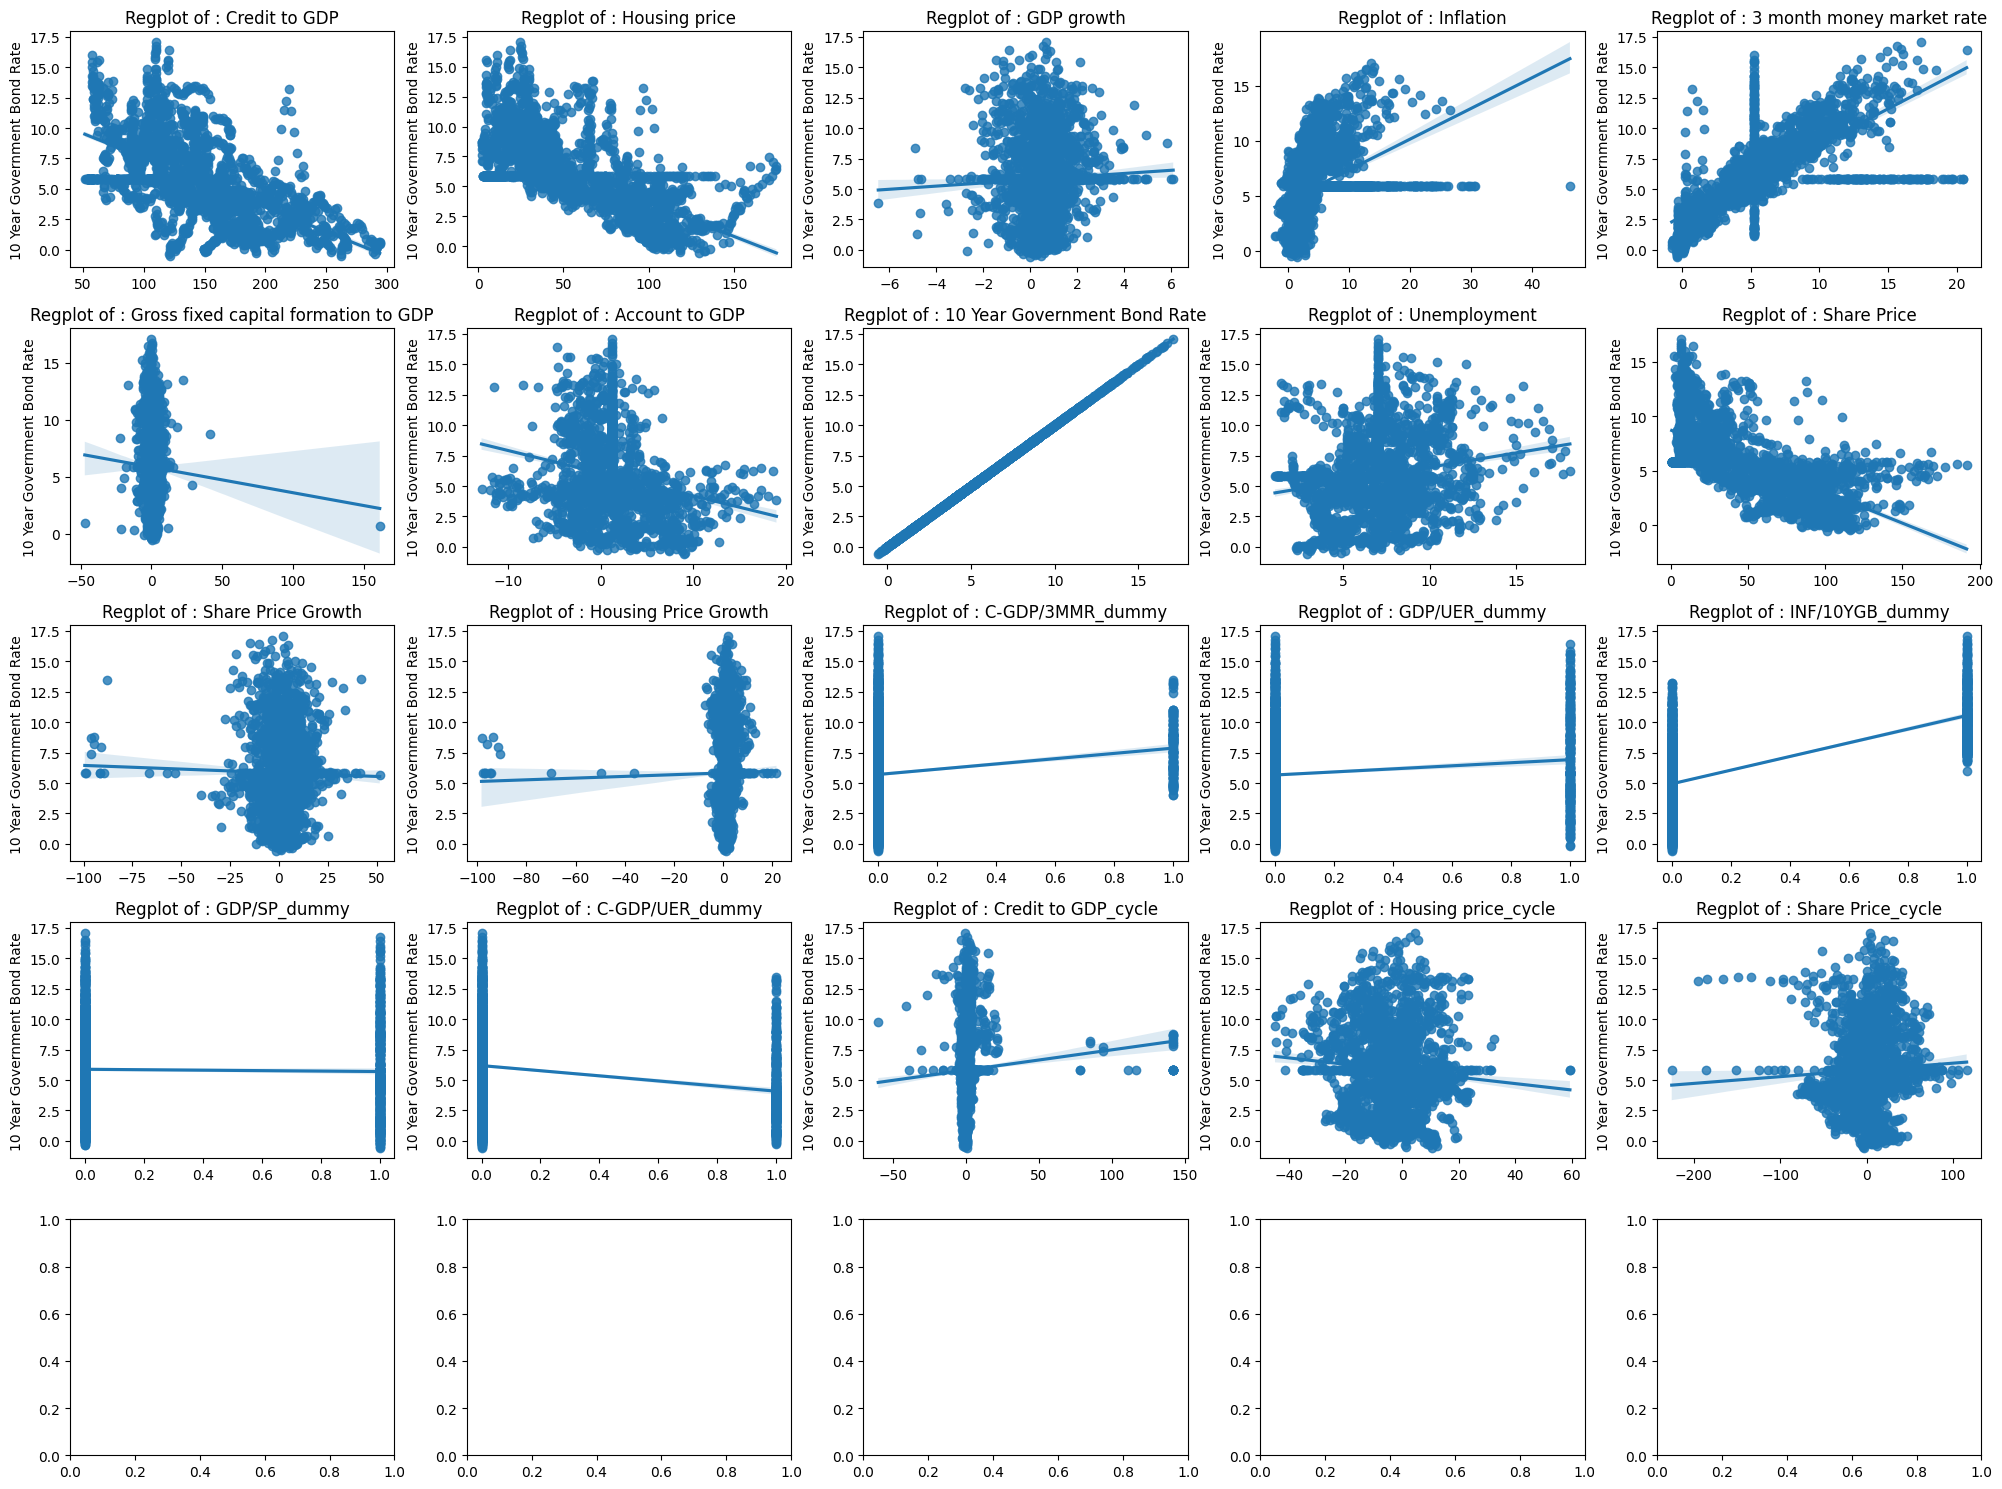

In [135]:
fig, axes = plt.subplots(ncols=5, nrows=5, figsize=(20, 15))

for i, ax in zip(df.columns[3:], axes.flat):
    sns.regplot(x=df[i], y=df["10 Year Government Bond Rate"], ax=ax)
    ax.set(title=f"Regplot of : {i}", xlabel="")

plt.tight_layout()
plt.show()

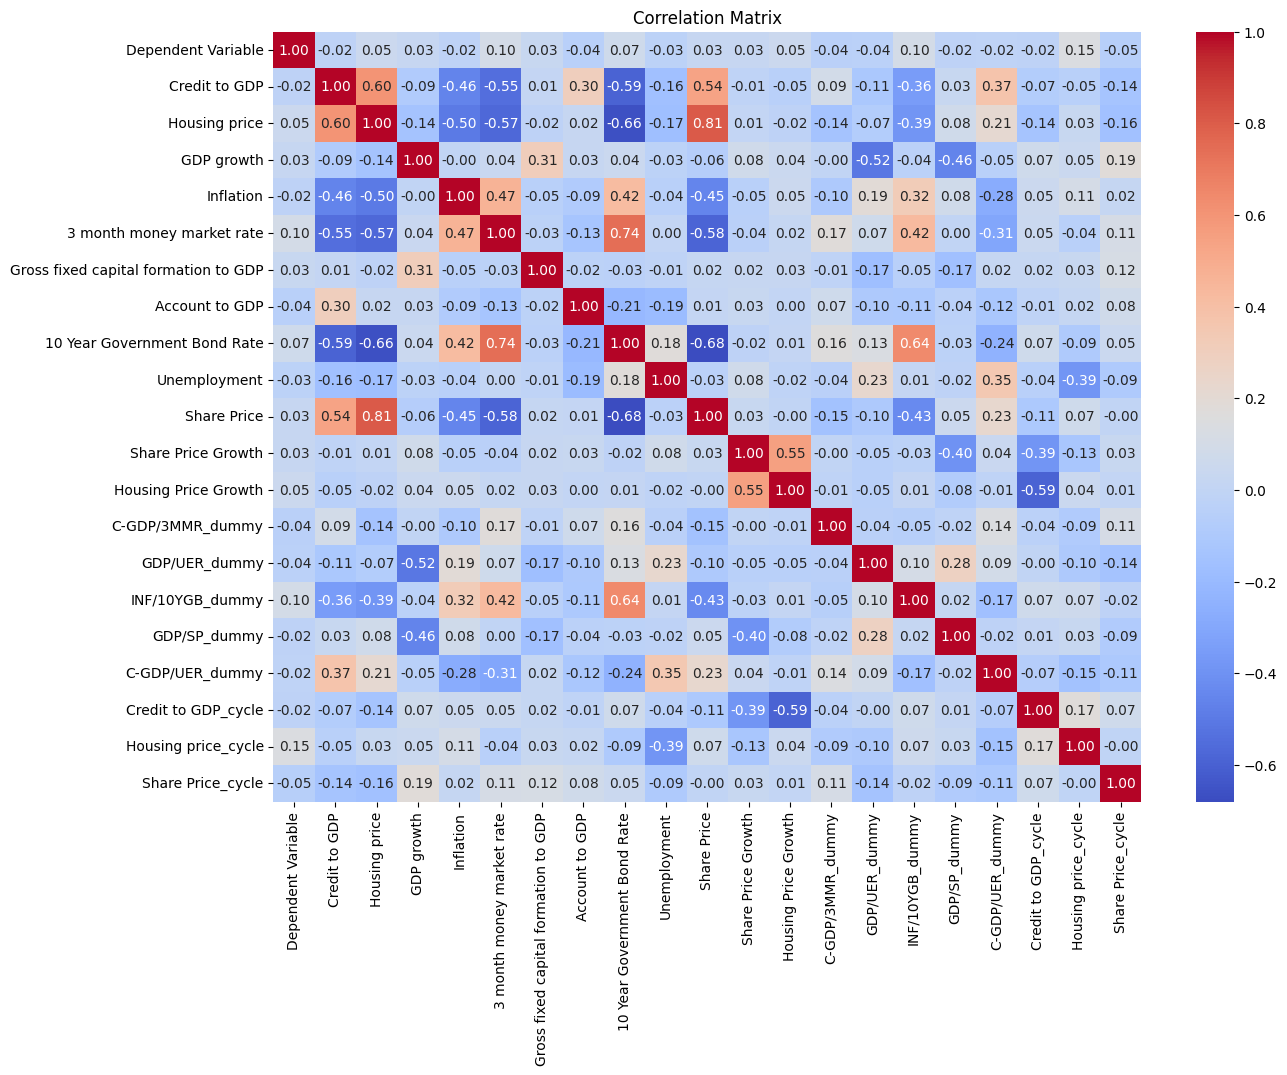

In [136]:
df.set_index(['Date', 'Country'], inplace=True)

correlation_matrix = df.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

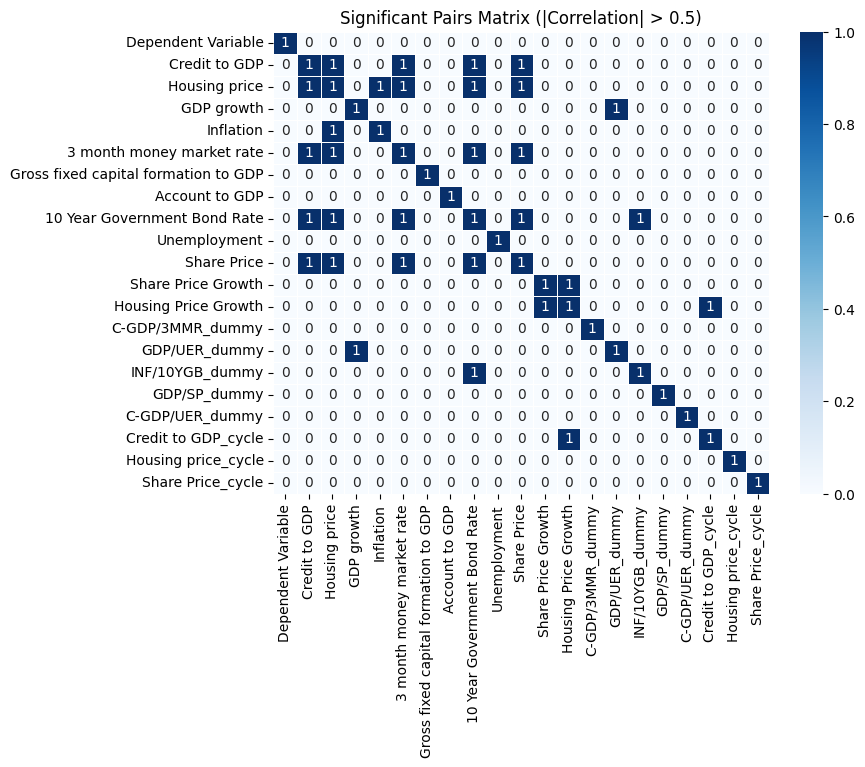

In [137]:
# Correlation Matrix with values more than |0.5|

df_significant = np.where(np.abs(correlation_matrix) > 0.5, 1, 0)

df_significant_pairs = pd.DataFrame(df_significant, index=correlation_matrix.columns, columns=correlation_matrix.columns)

plt.figure(figsize=(8, 6))
sns.heatmap(df_significant_pairs, annot=True, cmap='Blues', linewidths=.5)
plt.title('Significant Pairs Matrix (|Correlation| > 0.5)')
plt.show()

In [139]:
# Scaling

df.reset_index(inplace=True)

columns_to_scale = ['Credit to GDP', 'Housing price', 'GDP growth', 'Inflation',
                    '3 month money market rate', 'Gross fixed capital formation to GDP',
                    'Account to GDP', '10 Year Government Bond Rate', 'Unemployment',
                    'Share Price', 'Share Price Growth', 'Housing Price Growth',
                    'Credit to GDP_cycle', 'Housing price_cycle', 'Share Price_cycle']

data_to_scale = df[columns_to_scale]

scaler = RobustScaler()

scaled_data = scaler.fit_transform(data_to_scale)

scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)

norm_df = pd.concat([df[['Date', 'Country', 'Dependent Variable']],
                      scaled_df, df[['C-GDP/3MMR_dummy',
                           'GDP/UER_dummy', 'INF/10YGB_dummy', 'GDP/SP_dummy', 'C-GDP/UER_dummy']]], axis=1)


In [140]:
norm_df.head()

,Date,Country,Dependent Variable,Credit to GDP,Housing price,GDP growth,Inflation,3 month money market rate,Gross fixed capital formation to GDP,Account to GDP,...,Share Price Growth,Housing Price Growth,Credit to GDP_cycle,Housing price_cycle,Share Price_cycle,C-GDP/3MMR_dummy,GDP/UER_dummy,INF/10YGB_dummy,GDP/SP_dummy,C-GDP/UER_dummy
0,1970-Q1,DE,0,0.066500,-0.378047,-2.117735,0.034427,0.964538,-0.854207,0.0,...,NaN,NaN,69.439080,2.329830,4.240152e-01,0,1,0,0,0
1,1970-Q2,DE,0,0.066500,-0.365792,3.266147,0.128169,1.043603,2.517119,0.0,...,-1.290275,0.620349,69.439080,2.388976,3.824405e-01,0,0,0,0,0
2,1970-Q3,DE,0,0.066500,-0.353334,1.229144,0.177011,0.927243,1.575400,0.0,...,-0.797672,0.609531,-0.001025,0.075688,-2.258104e-10,0,0,0,0,0
3,1970-Q4,DE,0,-1.001414,-0.340626,0.243266,0.269112,0.806407,-0.205913,0.0,...,-0.710799,0.603119,-0.001025,0.075397,3.054537e-02,0,0,0,0,0
4,1971-Q1,DE,0,-0.997643,-0.328118,-2.432218,0.362734,0.503570,-0.689419,0.0,...,0.932099,0.557794,-7.435839,0.075030,4.608801e-02,0,1,0,0,0


In [145]:
norm_df.replace(np.nan, 0, inplace=True)
norm_df.isnull().sum()

Date                                    0
Country                                 0
Dependent Variable                      0
Credit to GDP                           0
Housing price                           0
GDP growth                              0
Inflation                               0
3 month money market rate               0
Gross fixed capital formation to GDP    0
Account to GDP                          0
10 Year Government Bond Rate            0
Unemployment                            0
Share Price                             0
Share Price Growth                      0
Housing Price Growth                    0
Credit to GDP_cycle                     0
Housing price_cycle                     0
Share Price_cycle                       0
C-GDP/3MMR_dummy                        0
GDP/UER_dummy                           0
INF/10YGB_dummy                         0
GDP/SP_dummy                            0
C-GDP/UER_dummy                         0
dtype: int64

In [146]:
# Setting 'Date' and 'Country' columns as index

norm_df['Date'] = pd.to_datetime(norm_df['Date'])
norm_df.set_index(['Country', 'Date'], inplace=True)
X = norm_df.drop('Dependent Variable', axis=1)
y = norm_df['Dependent Variable']

C:\Users\Asus\AppData\Local\Temp\ipykernel_7264\2289391135.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  norm_df['Date'] = pd.to_datetime(norm_df['Date'])


In [148]:
# Spliting data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Logistic Regression

In [149]:
lr = LogisticRegression(random_state=42).fit(X_train, y_train)
feature_names = norm_df.drop('Dependent Variable', axis=1)
coefficients = lr.coef_[0]
std_errors = np.std(X, 0) * np.sqrt((1 -  lr.score(X_train, y_train)) / (lr.score(X_train, y_train) * len(y_train)))

z_scores = coefficients / std_errors

p_values = [2 * (1 - norm.cdf(np.abs(z))) for z in z_scores]

for feature, coef, z, p in zip(feature_names, coefficients, z_scores, p_values):
    print(f"{feature}: Coefficient = {coef:.4f}, Z-score = {z:.4f}, P-value = {p:.4f}")
    intercept = lr.intercept_[0]

std_error_intercept = np.sqrt((1 - lr.score(X_train, y_train)) / (lr.score(X_train, y_train) * len(y_train)))

z_score_intercept = intercept / std_error_intercept

p_value_intercept = 2 * (1 - norm.cdf(np.abs(z_score_intercept)))

print(f"Intercept: {intercept:.4f}, Z-score = {z_score_intercept:.4f}, P-value = {p_value_intercept:.4f}")

Credit to GDP: Coefficient = 0.0011, Z-score = 0.1822, P-value = 0.8554
Housing price: Coefficient = 1.2426, Z-score = 325.8854, P-value = 0.0000
GDP growth: Coefficient = 0.1181, Z-score = 17.5259, P-value = 0.0000
Inflation: Coefficient = -0.4436, Z-score = -64.6284, P-value = 0.0000
3 month money market rate: Coefficient = 0.5871, Z-score = 96.4778, P-value = 0.0000
Gross fixed capital formation to GDP: Coefficient = 0.0368, Z-score = 3.5503, P-value = 0.0004
Account to GDP: Coefficient = -0.0176, Z-score = -1.2359, P-value = 0.2165
10 Year Government Bond Rate: Coefficient = 0.2404, Z-score = 41.1735, P-value = 0.0000
Unemployment: Coefficient = 0.2790, Z-score = 45.2361, P-value = 0.0000
Share Price: Coefficient = -0.0193, Z-score = -5.0564, P-value = 0.0000
Share Price Growth: Coefficient = 0.1247, Z-score = 15.4086, P-value = 0.0000
Housing Price Growth: Coefficient = 0.2725, Z-score = 14.1297, P-value = 0.0000
Credit to GDP_cycle: Coefficient = -0.0252, Z-score = -0.5758, P-val

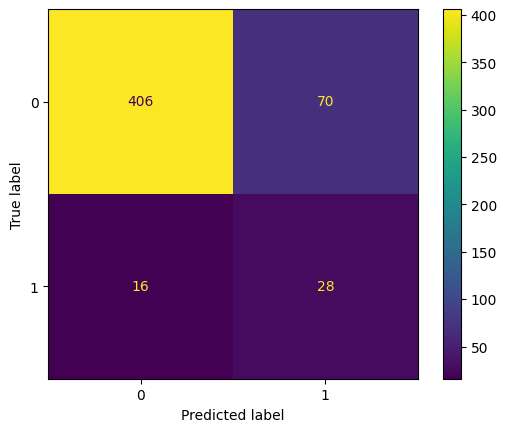

In [150]:
threshold = 0.13
y_probs_lr = lr.predict_proba(X_test)[:, 1]
y_pred_lr = np.where(y_probs_lr >= threshold, 1, 0)

confusion_matrix_lr = metrics.confusion_matrix(y_test, y_pred_lr)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_lr, display_labels = [0, 1])
cm_display.plot()
plt.show()

In [151]:
recall_score(y_test, y_pred_lr)

0.6363636363636364

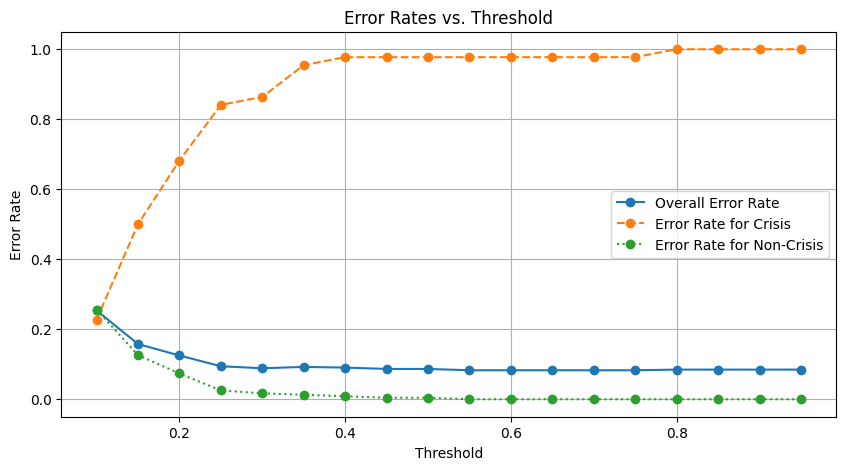

In [152]:
from sklearn.metrics import accuracy_score, confusion_matrix as cm

model = LogisticRegression()
result = model.fit(X_train, y_train)

predicted_probabilities = model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 1.0, 0.05)

overall_error_rates = []
default_error_rates = []
non_default_error_rates = []

for threshold in thresholds:
    predicted_labels = (predicted_probabilities >= threshold).astype(int)

    confusion = cm(y_test, predicted_labels)

    overall_error_rate = 1 - accuracy_score(y_test, predicted_labels)
    default_error_rate = confusion[1, 0] / (confusion[1, 0] + confusion[1, 1])  
    non_default_error_rate = confusion[0, 1] / (confusion[0, 0] + confusion[0, 1])  

    overall_error_rates.append(overall_error_rate)
    default_error_rates.append(default_error_rate)
    non_default_error_rates.append(non_default_error_rate)

plt.figure(figsize=(10, 5))
plt.plot(thresholds, overall_error_rates, label='Overall Error Rate', marker='o', linestyle='-')
plt.plot(thresholds, default_error_rates, label='Error Rate for Crisis', marker='o', linestyle='--')
plt.plot(thresholds, non_default_error_rates, label='Error Rate for Non-Crisis', marker='o', linestyle=':')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('Error Rates vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [153]:
TN, FP, FN, TP = confusion_matrix_lr.ravel()

mu = 0.9 
P1 = (TP + FN) / len(y_test) 
P2 = (TN + FP) / len(y_test)  

T1 = FN / (TP + FN)  
T2 = FP / (TN + FP)  

loss = mu * T1 * P1 + (1 - mu) * T2 * P2

min_loss = min(mu * P1, (1 - mu) * P2)
absolute_usefulness = min_loss - loss

max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
relative_usefulness = absolute_usefulness / max_possible_usefulness

print(f"Loss: {loss}")
print(f"Absolute Usefulness: {absolute_usefulness}")
print(f"Relative Usefulness: {relative_usefulness}")

Loss: 0.04115384615384615
Absolute Usefulness: 0.035
Relative Usefulness: 0.4595959595959596


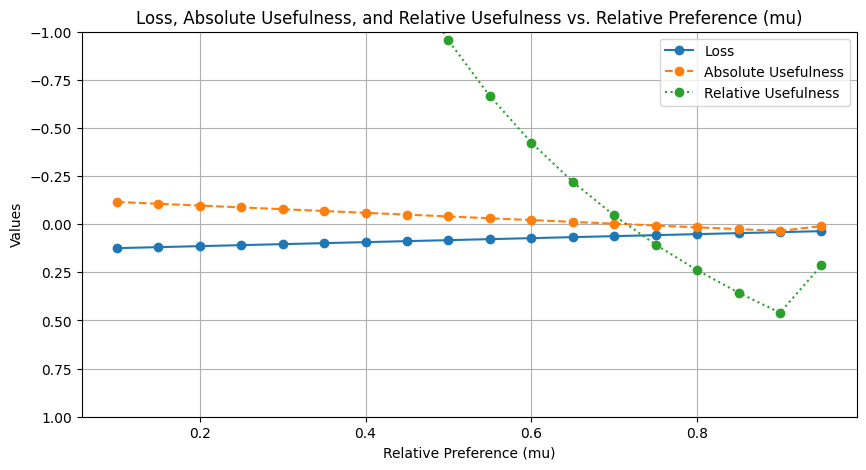

In [154]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix as cm

mu_values = np.arange(0.1, 1.0, 0.05)

loss_values = []
absolute_usefulness_values = []
relative_usefulness_values = []

for mu in mu_values:
    
    TN, FP, FN, TP = confusion_matrix_lr.ravel()

    P1 = (TP + FN) / len(y_test) 
    P2 = (TN + FP) / len(y_test) 

    T1 = FN / (TP + FN)  
    T2 = FP / (TN + FP)  
    loss = mu * T1 * P1 + (1 - mu) * T2 * P2

    min_loss = min(mu * P1, (1 - mu) * P2)
    absolute_usefulness = min_loss - loss

    max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
    relative_usefulness = absolute_usefulness / max_possible_usefulness

    loss_values.append(loss)
    absolute_usefulness_values.append(absolute_usefulness)
    relative_usefulness_values.append(relative_usefulness)

plt.figure(figsize=(10, 5))
plt.plot(mu_values, loss_values, label='Loss', marker='o', linestyle='-')
plt.plot(mu_values, absolute_usefulness_values, label='Absolute Usefulness', marker='o', linestyle='--')
plt.plot(mu_values, relative_usefulness_values, label='Relative Usefulness', marker='o', linestyle=':')
plt.xlabel('Relative Preference (mu)')
plt.ylabel('Values')
plt.title('Loss, Absolute Usefulness, and Relative Usefulness vs. Relative Preference (mu)')
plt.ylim(1, -1)  
plt.grid(True)
plt.legend()
plt.show()

LASSO/RIDGE

In [155]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
}

logistic = LogisticRegression(solver='saga', max_iter=1000)

grid_search = GridSearchCV(logistic, param_grid, cv=10, scoring='recall', verbose=1)

grid_search.fit(X_train, y_train)

print("Best hyperparameters for Logistic Regression:", grid_search.best_params_)
print("Best recall score for Logistic Regression:", grid_search.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: Convergen

Best hyperparameters for Logistic Regression: {'C': 1, 'penalty': 'l1'}
Best recall score for Logistic Regression: 0.02222222222222222


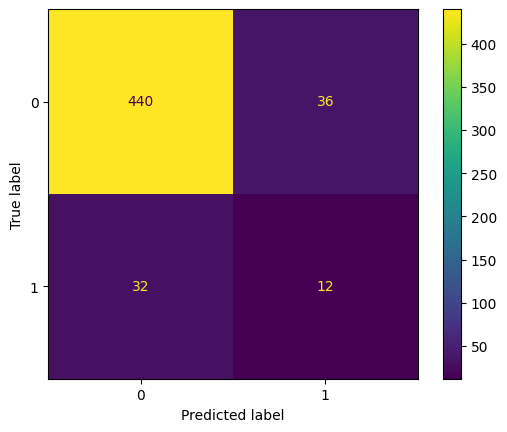

In [162]:
lasso = LogisticRegression(C=1, penalty='l1', solver='saga', max_iter=1000)
lasso.fit(X_train, y_train)

threshold = 0.2
y_probs_lasso = lasso.predict_proba(X_test)[:, 1]
y_pred_lasso = np.where(y_probs_lasso >= threshold, 1, 0)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix_lasso = confusion_matrix(y_test, y_pred_lasso)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_lasso, display_labels=[0, 1])
cm_display.plot()
plt.show()

In [163]:
recall_score(y_test, y_pred_lasso)

0.2727272727272727

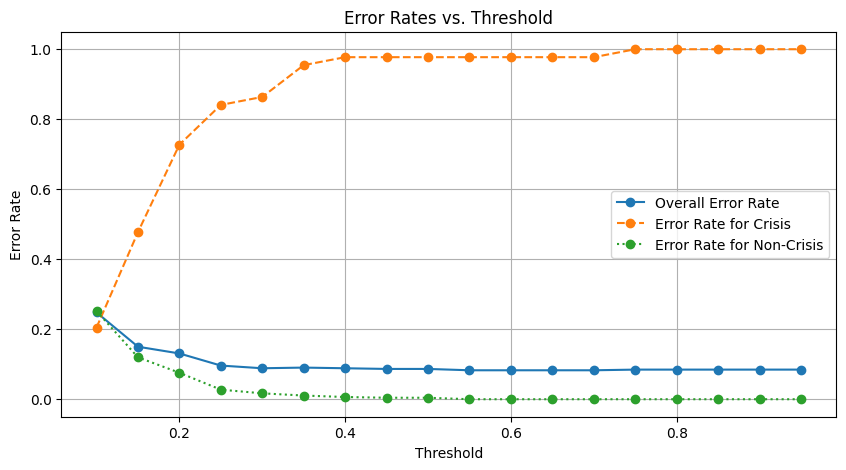

In [164]:
from sklearn.metrics import accuracy_score, confusion_matrix as cm
import matplotlib.pyplot as plt
import numpy as np

model = lasso  
model.fit(X_train, y_train)

predicted_probabilities = model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 1.0, 0.05)

overall_error_rates = []
default_error_rates = []
non_default_error_rates = []

for threshold in thresholds:
    predicted_labels = (predicted_probabilities >= threshold).astype(int)

    confusion = cm(y_test, predicted_labels)

    overall_error_rate = 1 - accuracy_score(y_test, predicted_labels)
    default_error_rate = confusion[1, 0] / (confusion[1, 0] + confusion[1, 1])  
    non_default_error_rate = confusion[0, 1] / (confusion[0, 0] + confusion[0, 1])  
    overall_error_rates.append(overall_error_rate)
    default_error_rates.append(default_error_rate)
    non_default_error_rates.append(non_default_error_rate)

plt.figure(figsize=(10, 5))
plt.plot(thresholds, overall_error_rates, label='Overall Error Rate', marker='o', linestyle='-')
plt.plot(thresholds, default_error_rates, label='Error Rate for Crisis', marker='o', linestyle='--')
plt.plot(thresholds, non_default_error_rates, label='Error Rate for Non-Crisis', marker='o', linestyle=':')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('Error Rates vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [167]:
TN, FP, FN, TP = confusion_matrix_lasso.ravel()

mu = 0.9  
P1 = (TP + FN) / len(y_test) 
P2 = (TN + FP) / len(y_test)  
T1 = FN / (TP + FN)  
T2 = FP / (TN + FP)  

loss = mu * T1 * P1 + (1 - mu) * T2 * P2

min_loss = min(mu * P1, (1 - mu) * P2)
absolute_usefulness = min_loss - loss

max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
relative_usefulness = absolute_usefulness / max_possible_usefulness

print(f"Loss: {loss}")
print(f"Absolute Usefulness: {absolute_usefulness}")
print(f"Relative Usefulness: {relative_usefulness}")

Loss: 0.06230769230769231
Absolute Usefulness: 0.013846153846153848
Relative Usefulness: 0.18181818181818185


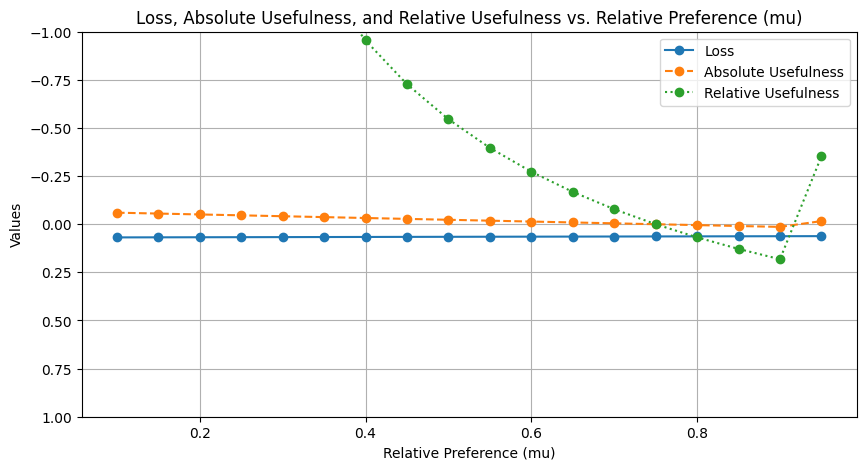

In [168]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix as cm

mu_values = np.arange(0.1, 1.0, 0.05)

loss_values = []
absolute_usefulness_values = []
relative_usefulness_values = []

for mu in mu_values:
    TN, FP, FN, TP = confusion_matrix_lasso.ravel()

    P1 = (TP + FN) / len(y_test) 
    P2 = (TN + FP) / len(y_test) 
    T1 = FN / (TP + FN)  
    T2 = FP / (TN + FP)  

    loss = mu * T1 * P1 + (1 - mu) * T2 * P2

    min_loss = min(mu * P1, (1 - mu) * P2)
    absolute_usefulness = min_loss - loss

    max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
    relative_usefulness = absolute_usefulness / max_possible_usefulness

    loss_values.append(loss)
    absolute_usefulness_values.append(absolute_usefulness)
    relative_usefulness_values.append(relative_usefulness)

plt.figure(figsize=(10, 5))
plt.plot(mu_values, loss_values, label='Loss', marker='o', linestyle='-')
plt.plot(mu_values, absolute_usefulness_values, label='Absolute Usefulness', marker='o', linestyle='--')
plt.plot(mu_values, relative_usefulness_values, label='Relative Usefulness', marker='o', linestyle=':')
plt.xlabel('Relative Preference (mu)')
plt.ylabel('Values')
plt.title('Loss, Absolute Usefulness, and Relative Usefulness vs. Relative Preference (mu)')
plt.ylim(1, -1)  
plt.grid(True)
plt.legend()
plt.show()

KNN

In [169]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn_grid = GridSearchCV(knn, param_grid, cv=5, scoring='recall')

knn_grid.fit(X_train, y_train)

best_knn_params = knn_grid.best_params_
best_knn_score = knn_grid.best_score_

print("Best hyperparameters for KNN:", best_knn_params)
print("Best recall score for KNN:", best_knn_score)


Best hyperparameters for KNN: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best recall score for KNN: 0.7010510510510511


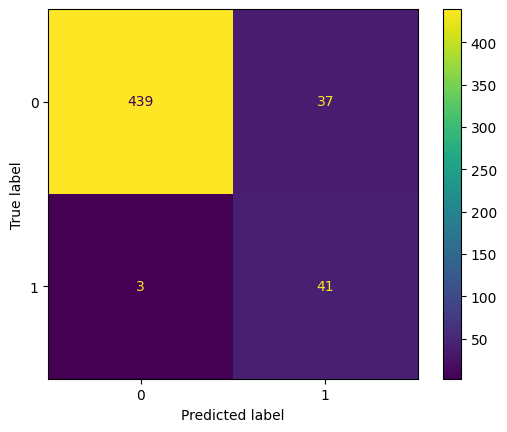

In [170]:
knn = KNeighborsClassifier(n_neighbors= 3, p= 1, weights='uniform')
knn.fit(X_train, y_train)

threshold = 0.2

y_probs_knn = knn.predict_proba(X_test)[:, 1]
y_pred_knn = np.where(y_probs_knn >= threshold, 1, 0)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix_knn = confusion_matrix(y_test, y_pred_knn)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_knn, display_labels=[0, 1])
cm_display.plot()
plt.show()

In [171]:
recall_score(y_test, y_pred_knn)

0.9318181818181818

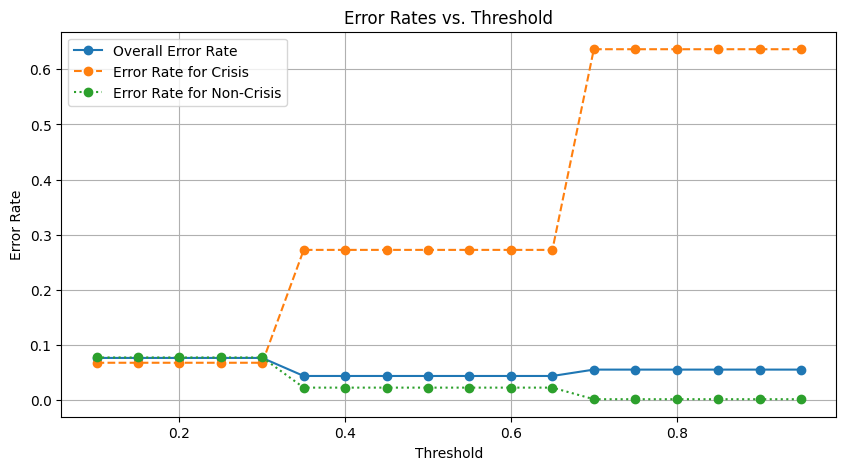

In [172]:
from sklearn.metrics import accuracy_score, confusion_matrix as cm
import matplotlib.pyplot as plt
import numpy as np

model = knn  

model.fit(X_train, y_train)

predicted_probabilities = model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 1.0, 0.05)

overall_error_rates = []
default_error_rates = []
non_default_error_rates = []

for threshold in thresholds:
    predicted_labels = (predicted_probabilities >= threshold).astype(int)

    confusion = cm(y_test, predicted_labels)

    overall_error_rate = 1 - accuracy_score(y_test, predicted_labels)
    default_error_rate = confusion[1, 0] / (confusion[1, 0] + confusion[1, 1])  
    non_default_error_rate = confusion[0, 1] / (confusion[0, 0] + confusion[0, 1]) 

    overall_error_rates.append(overall_error_rate)
    default_error_rates.append(default_error_rate)
    non_default_error_rates.append(non_default_error_rate)

plt.figure(figsize=(10, 5))
plt.plot(thresholds, overall_error_rates, label='Overall Error Rate', marker='o', linestyle='-')
plt.plot(thresholds, default_error_rates, label='Error Rate for Crisis', marker='o', linestyle='--')
plt.plot(thresholds, non_default_error_rates, label='Error Rate for Non-Crisis', marker='o', linestyle=':')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('Error Rates vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [173]:
TN, FP, FN, TP = confusion_matrix_knn.ravel()

mu = 0.8 
P1 = (TP + FN) / len(y_test)  
P2 = (TN + FP) / len(y_test)  

T1 = FN / (TP + FN)  
T2 = FP / (TN + FP)  

loss = mu * T1 * P1 + (1 - mu) * T2 * P2

min_loss = min(mu * P1, (1 - mu) * P2)
absolute_usefulness = min_loss - loss

max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
relative_usefulness = absolute_usefulness / max_possible_usefulness

print(f"Loss: {loss}")
print(f"Absolute Usefulness: {absolute_usefulness}")
print(f"Relative Usefulness: {relative_usefulness}")

Loss: 0.018846153846153842
Absolute Usefulness: 0.04884615384615386
Relative Usefulness: 0.7215909090909092


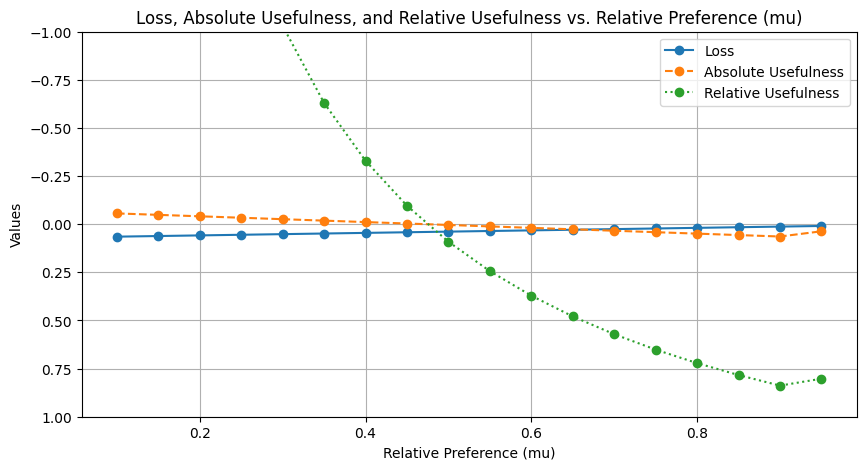

In [174]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix as cm

mu_values = np.arange(0.1, 1.0, 0.05)

loss_values = []
absolute_usefulness_values = []
relative_usefulness_values = []

for mu in mu_values:
    TN, FP, FN, TP = confusion_matrix_knn.ravel()

    P1 = (TP + FN) / len(y_test) 
    P2 = (TN + FP) / len(y_test)  

    T1 = FN / (TP + FN) 
    T2 = FP / (TN + FP)  
    loss = mu * T1 * P1 + (1 - mu) * T2 * P2

    min_loss = min(mu * P1, (1 - mu) * P2)
    absolute_usefulness = min_loss - loss

    max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
    relative_usefulness = absolute_usefulness / max_possible_usefulness

    loss_values.append(loss)
    absolute_usefulness_values.append(absolute_usefulness)
    relative_usefulness_values.append(relative_usefulness)

plt.figure(figsize=(10, 5))
plt.plot(mu_values, loss_values, label='Loss', marker='o', linestyle='-')
plt.plot(mu_values, absolute_usefulness_values, label='Absolute Usefulness', marker='o', linestyle='--')
plt.plot(mu_values, relative_usefulness_values, label='Relative Usefulness', marker='o', linestyle=':')
plt.xlabel('Relative Preference (mu)')
plt.ylabel('Values')
plt.title('Loss, Absolute Usefulness, and Relative Usefulness vs. Relative Preference (mu)')
plt.ylim(1, -1) 
plt.grid(True)
plt.legend()
plt.show()

SVM

In [176]:
%%time

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svm = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'] + [0.001, 0.01, 0.1, 1]
}

svm_grid = GridSearchCV(svm, param_grid, cv=5, scoring='recall')

svm_grid.fit(X_train, y_train)

best_svm_params = svm_grid.best_params_
best_svm_score = svm_grid.best_score_

print("Best hyperparameters for SVM:", best_svm_params)
print("Best recall score for SVM:", best_svm_score)

Best hyperparameters for SVM: {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
Best recall score for SVM: 0.5687687687687688
CPU times: total: 39.7 s
Wall time: 1min 35s


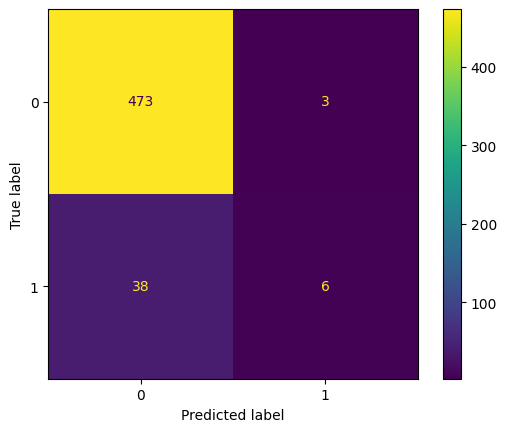

In [189]:
from sklearn.svm import SVC
svm = SVC(C=0.1, gamma=1, kernel='poly', probability=True)
svm.fit(X_train, y_train)

threshold = 0.2
y_probs_svm = svm.predict_proba(X_test)[:, 1]
y_pred_svm = np.where(y_probs_svm >= threshold, 1, 0)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix_svm = confusion_matrix(y_test, y_pred_svm)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_svm, display_labels=[0, 1])
cm_display.plot()
plt.show()

In [190]:
recall_score(y_test, y_pred_svm)

0.13636363636363635

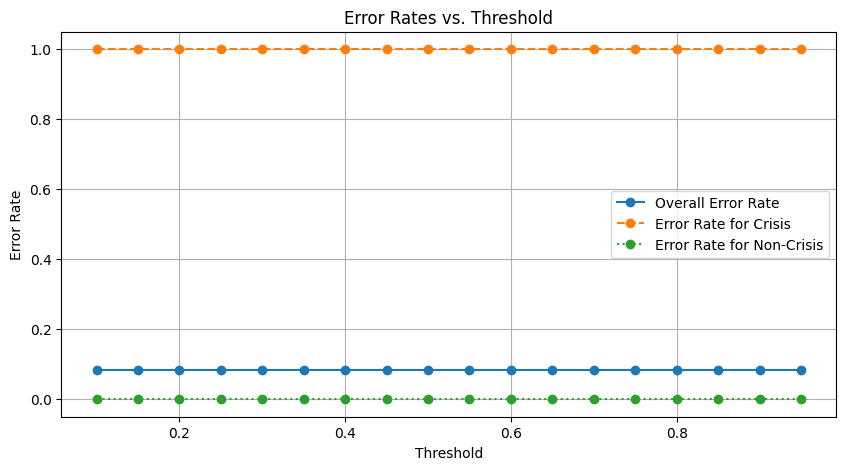

In [191]:
from sklearn.metrics import accuracy_score, confusion_matrix as cm
import matplotlib.pyplot as plt
import numpy as np

model = svm 

model.fit(X_train, y_train)

predicted_probabilities = model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 1.0, 0.05)

overall_error_rates = []
default_error_rates = []
non_default_error_rates = []

for threshold in thresholds:
    predicted_labels = (predicted_probabilities >= threshold).astype(int)

    confusion = cm(y_test, predicted_labels)

    overall_error_rate = 1 - accuracy_score(y_test, predicted_labels)
    default_error_rate = confusion[1, 0] / (confusion[1, 0] + confusion[1, 1])  
    non_default_error_rate = confusion[0, 1] / (confusion[0, 0] + confusion[0, 1])  

    overall_error_rates.append(overall_error_rate)
    default_error_rates.append(default_error_rate)
    non_default_error_rates.append(non_default_error_rate)

plt.figure(figsize=(10, 5))
plt.plot(thresholds, overall_error_rates, label='Overall Error Rate', marker='o', linestyle='-')
plt.plot(thresholds, default_error_rates, label='Error Rate for Crisis', marker='o', linestyle='--')
plt.plot(thresholds, non_default_error_rates, label='Error Rate for Non-Crisis', marker='o', linestyle=':')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('Error Rates vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [192]:
TN, FP, FN, TP = confusion_matrix_svm.ravel()

mu = 0.9 
P1 = (TP + FN) / len(y_test) 
P2 = (TN + FP) / len(y_test)  
T1 = FN / (TP + FN)  
T2 = FP / (TN + FP) 

loss = mu * T1 * P1 + (1 - mu) * T2 * P2

min_loss = min(mu * P1, (1 - mu) * P2)
absolute_usefulness = min_loss - loss

max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
relative_usefulness = absolute_usefulness / max_possible_usefulness

print(f"Loss: {loss}")
print(f"Absolute Usefulness: {absolute_usefulness}")
print(f"Relative Usefulness: {relative_usefulness}")

Loss: 0.06634615384615385
Absolute Usefulness: 0.009807692307692309
Relative Usefulness: 0.1287878787878788


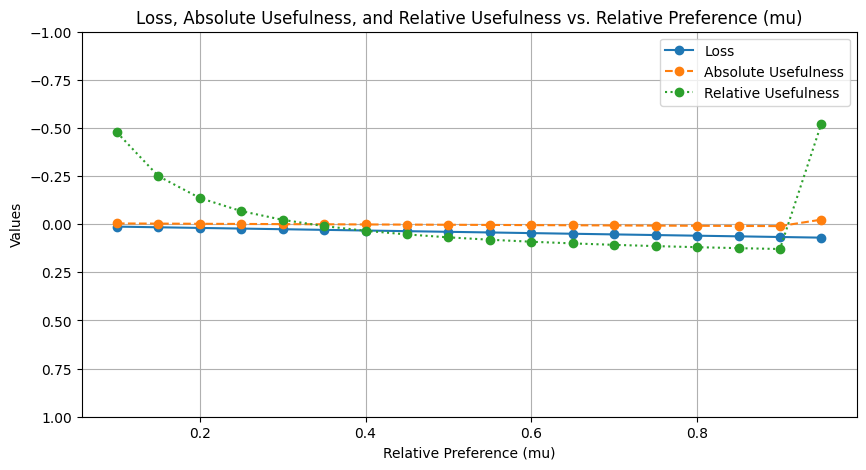

In [193]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix as cm

mu_values = np.arange(0.1, 1.0, 0.05)

loss_values = []
absolute_usefulness_values = []
relative_usefulness_values = []

for mu in mu_values:
    TN, FP, FN, TP = confusion_matrix_svm.ravel()

    P1 = (TP + FN) / len(y_test)  
    P2 = (TN + FP) / len(y_test)  
    T1 = FN / (TP + FN) 
    T2 = FP / (TN + FP) 

    loss = mu * T1 * P1 + (1 - mu) * T2 * P2

    min_loss = min(mu * P1, (1 - mu) * P2)
    absolute_usefulness = min_loss - loss

    max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
    relative_usefulness = absolute_usefulness / max_possible_usefulness

    loss_values.append(loss)
    absolute_usefulness_values.append(absolute_usefulness)
    relative_usefulness_values.append(relative_usefulness)

plt.figure(figsize=(10, 5))
plt.plot(mu_values, loss_values, label='Loss', marker='o', linestyle='-')
plt.plot(mu_values, absolute_usefulness_values, label='Absolute Usefulness', marker='o', linestyle='--')
plt.plot(mu_values, relative_usefulness_values, label='Relative Usefulness', marker='o', linestyle=':')
plt.xlabel('Relative Preference (mu)')
plt.ylabel('Values')
plt.title('Loss, Absolute Usefulness, and Relative Usefulness vs. Relative Preference (mu)')
plt.ylim(1, -1)  
plt.grid(True)
plt.legend()
plt.show()

Decision Tree

In [194]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_grid = GridSearchCV(dt, param_grid, cv=5, scoring='recall')

dt_grid.fit(X_train, y_train)

best_dt_params = dt_grid.best_params_
best_dt_score = dt_grid.best_score_

print("Best hyperparameters for Decision Tree:", best_dt_params)
print("Best recall score for Decision Tree:", best_dt_score)


Best hyperparameters for Decision Tree: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best recall score for Decision Tree: 0.6351351351351351


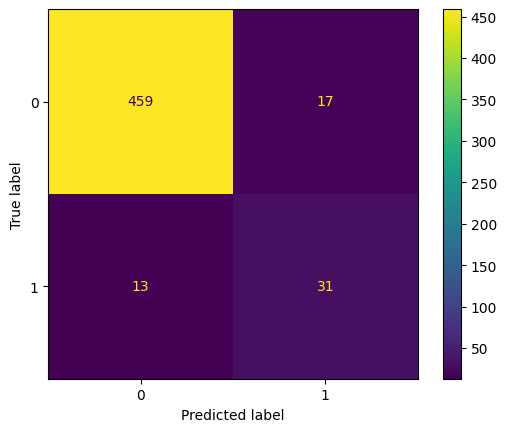

In [196]:
dt = DecisionTreeClassifier(criterion= 'gini', max_depth= None, min_samples_leaf=1, min_samples_split=5)
dt.fit(X_train, y_train)

threshold = 0.3
y_probs_dt = dt.predict_proba(X_test)[:, 1]
y_pred_dt = np.where(y_probs_dt >= threshold, 1, 0)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix_dt = confusion_matrix(y_test, y_pred_dt)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dt, display_labels=[0, 1])
cm_display.plot()
plt.show()

In [197]:
recall_score(y_test, y_pred_dt)

0.7045454545454546

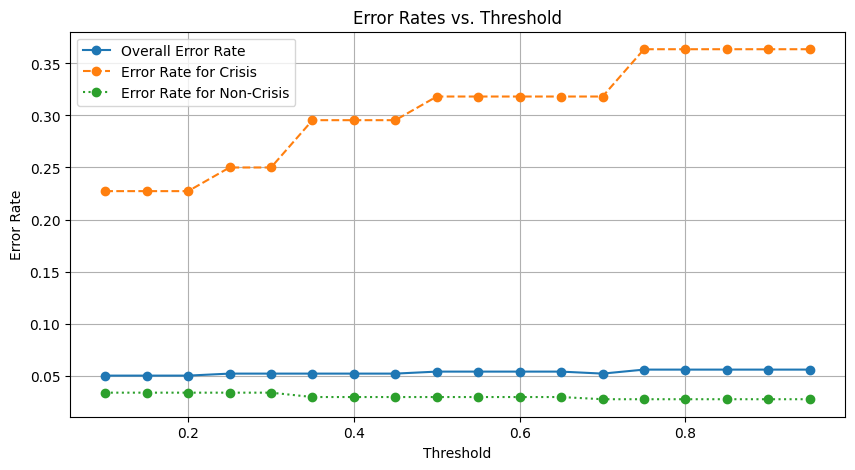

In [198]:
from sklearn.metrics import accuracy_score, confusion_matrix as cm
import matplotlib.pyplot as plt
import numpy as np

model = dt 
model.fit(X_train, y_train)

predicted_probabilities = model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 1.0, 0.05)

overall_error_rates = []
default_error_rates = []
non_default_error_rates = []

for threshold in thresholds:
    predicted_labels = (predicted_probabilities >= threshold).astype(int)

    confusion = cm(y_test, predicted_labels)

    overall_error_rate = 1 - accuracy_score(y_test, predicted_labels)
    default_error_rate = confusion[1, 0] / (confusion[1, 0] + confusion[1, 1])  
    non_default_error_rate = confusion[0, 1] / (confusion[0, 0] + confusion[0, 1])  
    overall_error_rates.append(overall_error_rate)
    default_error_rates.append(default_error_rate)
    non_default_error_rates.append(non_default_error_rate)

plt.figure(figsize=(10, 5))
plt.plot(thresholds, overall_error_rates, label='Overall Error Rate', marker='o', linestyle='-')
plt.plot(thresholds, default_error_rates, label='Error Rate for Crisis', marker='o', linestyle='--')
plt.plot(thresholds, non_default_error_rates, label='Error Rate for Non-Crisis', marker='o', linestyle=':')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('Error Rates vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [199]:

TN, FP, FN, TP = confusion_matrix_dt.ravel()

mu = 0.9
P1 = (TP + FN) / len(y_test) 
P2 = (TN + FP) / len(y_test)  

T1 = FN / (TP + FN) 
T2 = FP / (TN + FP)  

loss = mu * T1 * P1 + (1 - mu) * T2 * P2

min_loss = min(mu * P1, (1 - mu) * P2)
absolute_usefulness = min_loss - loss

max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
relative_usefulness = absolute_usefulness / max_possible_usefulness

print(f"Loss: {loss}")
print(f"Absolute Usefulness: {absolute_usefulness}")
print(f"Relative Usefulness: {relative_usefulness}")

Loss: 0.02576923076923077
Absolute Usefulness: 0.05038461538461539
Relative Usefulness: 0.6616161616161617


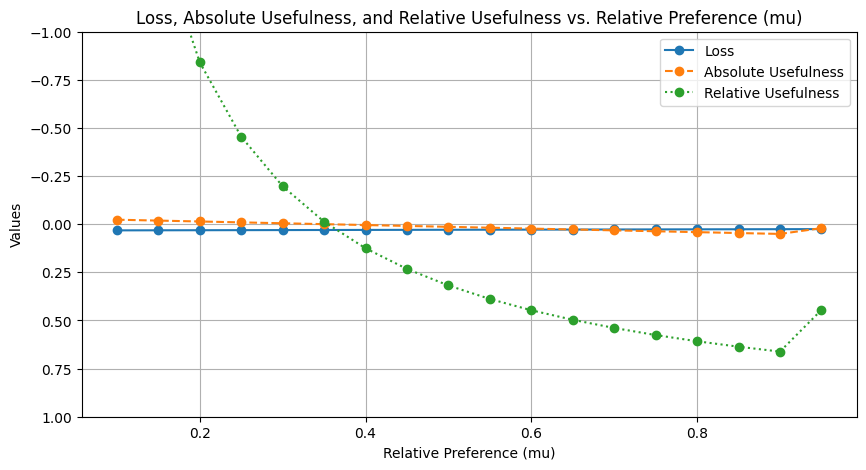

In [200]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix as cm

mu_values = np.arange(0.1, 1.0, 0.05)

loss_values = []
absolute_usefulness_values = []
relative_usefulness_values = []

for mu in mu_values:
    TN, FP, FN, TP = confusion_matrix_dt.ravel()

    P1 = (TP + FN) / len(y_test) 
    P2 = (TN + FP) / len(y_test) 

    T1 = FN / (TP + FN)  
    T2 = FP / (TN + FP)  
    loss = mu * T1 * P1 + (1 - mu) * T2 * P2

    min_loss = min(mu * P1, (1 - mu) * P2)
    absolute_usefulness = min_loss - loss

    max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
    relative_usefulness = absolute_usefulness / max_possible_usefulness

    loss_values.append(loss)
    absolute_usefulness_values.append(absolute_usefulness)
    relative_usefulness_values.append(relative_usefulness)

plt.figure(figsize=(10, 5))
plt.plot(mu_values, loss_values, label='Loss', marker='o', linestyle='-')
plt.plot(mu_values, absolute_usefulness_values, label='Absolute Usefulness', marker='o', linestyle='--')
plt.plot(mu_values, relative_usefulness_values, label='Relative Usefulness', marker='o', linestyle=':')
plt.xlabel('Relative Preference (mu)')
plt.ylabel('Values')
plt.title('Loss, Absolute Usefulness, and Relative Usefulness vs. Relative Preference (mu)')
plt.ylim(1, -1)  
plt.grid(True)
plt.legend()
plt.show()

Random Forest

In [203]:
%%time

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(rf, param_grid, cv=5, scoring='recall')

rf_grid.fit(X_train, y_train)

best_rf_params = rf_grid.best_params_
best_rf_score = rf_grid.best_score_

print("Best hyperparameters for Random Forest:", best_rf_params)
print("Best recall score for Random Forest:", best_rf_score)


Best hyperparameters for Random Forest: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best recall score for Random Forest: 0.43108108108108106
CPU times: total: 16min 31s
Wall time: 27min 54s


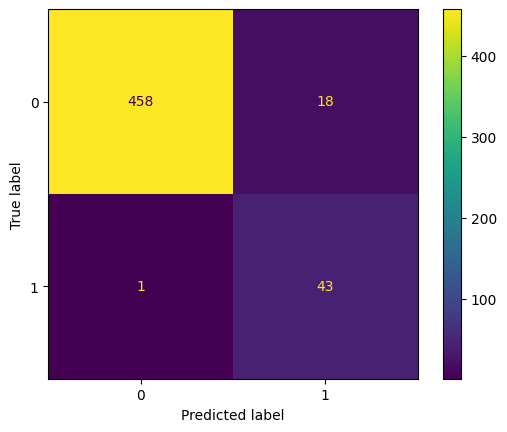

In [204]:
rf = RandomForestClassifier(criterion= 'entropy', max_depth= 20, min_samples_leaf=1, min_samples_split=2, n_estimators=100)
rf.fit(X_train, y_train)

threshold = 0.2
y_probs_rf = rf.predict_proba(X_test)[:, 1]
y_pred_rf = np.where(y_probs_rf >= threshold, 1, 0)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix_rf = confusion_matrix(y_test, y_pred_rf)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_rf, display_labels=[0, 1])
cm_display.plot()
plt.show()

In [205]:
recall_score(y_test, y_pred_rf)

0.9772727272727273

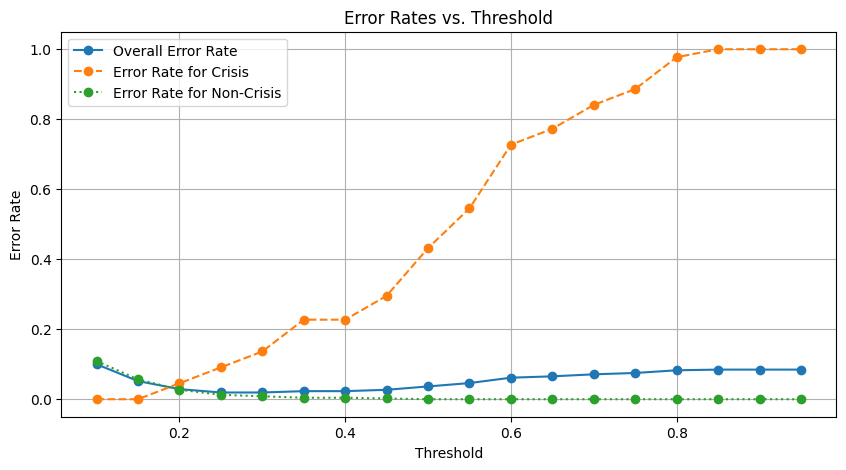

In [206]:
from sklearn.metrics import accuracy_score, confusion_matrix as cm
import matplotlib.pyplot as plt
import numpy as np

model = rf  
model.fit(X_train, y_train)

predicted_probabilities = model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 1.0, 0.05)

overall_error_rates = []
default_error_rates = []
non_default_error_rates = []

for threshold in thresholds:
    predicted_labels = (predicted_probabilities >= threshold).astype(int)

    confusion = cm(y_test, predicted_labels)

    overall_error_rate = 1 - accuracy_score(y_test, predicted_labels)
    default_error_rate = confusion[1, 0] / (confusion[1, 0] + confusion[1, 1]) 
    non_default_error_rate = confusion[0, 1] / (confusion[0, 0] + confusion[0, 1])  
    overall_error_rates.append(overall_error_rate)
    default_error_rates.append(default_error_rate)
    non_default_error_rates.append(non_default_error_rate)

plt.figure(figsize=(10, 5))
plt.plot(thresholds, overall_error_rates, label='Overall Error Rate', marker='o', linestyle='-')
plt.plot(thresholds, default_error_rates, label='Error Rate for Crisis', marker='o', linestyle='--')
plt.plot(thresholds, non_default_error_rates, label='Error Rate for Non-Crisis', marker='o', linestyle=':')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('Error Rates vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [207]:
TN, FP, FN, TP = confusion_matrix_rf.ravel()

mu = 0.9  
P1 = (TP + FN) / len(y_test)  
P2 = (TN + FP) / len(y_test)  
T1 = FN / (TP + FN)  
T2 = FP / (TN + FP)  
loss = mu * T1 * P1 + (1 - mu) * T2 * P2

min_loss = min(mu * P1, (1 - mu) * P2)
absolute_usefulness = min_loss - loss

max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
relative_usefulness = absolute_usefulness / max_possible_usefulness

print(f"Loss: {loss}")
print(f"Absolute Usefulness: {absolute_usefulness}")
print(f"Relative Usefulness: {relative_usefulness}")

Loss: 0.005192307692307691
Absolute Usefulness: 0.07096153846153846
Relative Usefulness: 0.9318181818181819


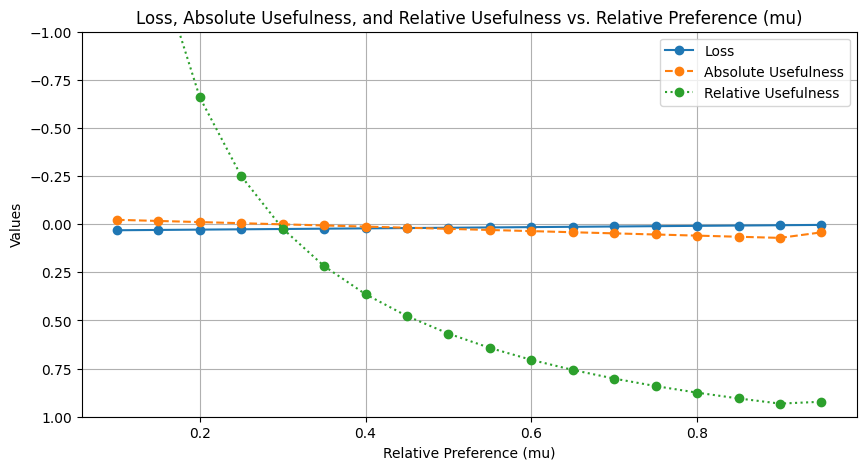

In [208]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix as cm

mu_values = np.arange(0.1, 1.0, 0.05)

loss_values = []
absolute_usefulness_values = []
relative_usefulness_values = []

for mu in mu_values:
    TN, FP, FN, TP = confusion_matrix_rf.ravel()

    P1 = (TP + FN) / len(y_test) 
    P2 = (TN + FP) / len(y_test) 
    T1 = FN / (TP + FN)  
    T2 = FP / (TN + FP)  
    loss = mu * T1 * P1 + (1 - mu) * T2 * P2

    min_loss = min(mu * P1, (1 - mu) * P2)
    absolute_usefulness = min_loss - loss

    max_possible_usefulness = min(mu * P1, (1 - mu) * P2)
    relative_usefulness = absolute_usefulness / max_possible_usefulness

    loss_values.append(loss)
    absolute_usefulness_values.append(absolute_usefulness)
    relative_usefulness_values.append(relative_usefulness)

plt.figure(figsize=(10, 5))
plt.plot(mu_values, loss_values, label='Loss', marker='o', linestyle='-')
plt.plot(mu_values, absolute_usefulness_values, label='Absolute Usefulness', marker='o', linestyle='--')
plt.plot(mu_values, relative_usefulness_values, label='Relative Usefulness', marker='o', linestyle=':')
plt.xlabel('Relative Preference (mu)')
plt.ylabel('Values')
plt.title('Loss, Absolute Usefulness, and Relative Usefulness vs. Relative Preference (mu)')
plt.ylim(1, -1)  
plt.grid(True)
plt.legend()
plt.show()

Till this point everything is done, I just want to add RNN. Unfortunatelly I'm facing some problems with !pip install tensorflow==2.0.

RNN

In [213]:
import numpy as np
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import make_scorer
from keras.optimizers import Adam

def create_rnn_model(learning_rate=0.001, units=50):
    model = Sequential()
    model.add(SimpleRNN(units, input_shape=(X_train.shape[1], 1), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

rnn_model = KerasClassifier(build_fn=create_rnn_model, epochs=10, batch_size=32, verbose=0)

param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'units': [50, 100, 150],
}

tscv = TimeSeriesSplit(n_splits=5)

scorer = make_scorer('accuracy')

rnn_grid = GridSearchCV(rnn_model, param_grid, cv=tscv, scoring=scorer, n_jobs=-1)

X_train_rnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

rnn_grid_result = rnn_grid.fit(X_train_rnn, y_train)

best_rnn_params = rnn_grid_result.best_params_
best_rnn_score = rnn_grid_result.best_score_

print("Best hyperparameters for RNN:", best_rnn_params)
print("Best accuracy score for RNN:", best_rnn_score)

ModuleNotFoundError: No module named 'tensorflow.python'

In [ ]:
rnn = KerasClassifier(n_estimators= 100, learning_rate=0.1,  max_depth= None, min_samples_leaf=1, min_samples_split=5)
rnn.fit(X_train, y_train)

threshold = 0.3
y_probs_gb = gb.predict_proba(X_test)[:, 1]
y_pred_gb = np.where(y_probs_gb >= threshold, 1, 0)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix_gb = confusion_matrix(y_test, y_pred_gb)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_gb, display_labels=[0, 1])
cm_display.plot()
plt.show()

Now we apply PCA(Principal Component Analysis with LR, KNN, SVM, DT, RF, and RNN) in order to reduce the dimensionality and then to use how these models will perform with PCA.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

def apply_pca_and_grid_search(model, param_grid, model_name):
    pca = PCA()

    pipeline = Pipeline([('pca', pca), ('model', model)])

    param_grid_pca = {
        'pca__n_components': [5, 10, 15],  
        **param_grid
    }

    grid = GridSearchCV(pipeline, param_grid_pca, cv=5, scoring='recall', n_jobs=-1)

    grid.fit(X_train, y_train)

    best_params = grid.best_params_
    best_score = grid.best_score_

    print(f"Best hyperparameters for {model_name} with PCA:", best_params)
    print(f"Best recall score for {model_name} with PCA:", best_score)

In [ ]:
# Apply PCA and grid search for Logistic Regression
logistic_regression = LogisticRegression()
param_grid_logistic_regression = {
    'model__penalty': ['l1', 'l2'],
    'model__C': [0.1, 1, 10]
}
apply_pca_and_grid_search(logistic_regression, param_grid_logistic_regression, 'Logistic Regression')


In [ ]:
# Apply PCA and grid search for KNN
knn = KNeighborsClassifier()
param_grid_knn = {
    'model__n_neighbors': [3, 5, 7, 9],
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2]
}
apply_pca_and_grid_search(knn, param_grid_knn, 'KNN')

In [ ]:
# Apply PCA and grid search for SVM
svm = SVC()
param_grid_svm = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf', 'poly'],
    'model__gamma': ['scale', 'auto'] + [0.001, 0.01, 0.1, 1]
}
apply_pca_and_grid_search(svm, param_grid_svm, 'SVM')



In [ ]:
# Apply PCA and grid search for Decision Tree
dt = DecisionTreeClassifier()
param_grid_dt = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}
apply_pca_and_grid_search(dt, param_grid_dt, 'Decision Tree')



In [ ]:
# Apply PCA and grid search for Random Forest
rf = RandomForestClassifier()
param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}
apply_pca_and_grid_search(rf, param_grid_rf, 'Random Forest')



In [ ]:
# Apply PCA and grid search for Recurrent Neural Network
rnn = KerasClassifier()
param_grid_rnn = {
    'learning_rate': [0.1, 0.01, 0.001],
    'units': [50, 100, 150],
}

apply_pca_and_grid_search(rnn, param_grid_rnn, 'Recurrent Neural Network')